In [27]:
# Imports and utils

import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

import sys
sys.path.append('../../')
sys.path.append('../../..')
sys.path.append('')

sys.path.append('/home/yau/sequencing_the_neuron/reconstruction/uti')

from mdistiller.models import cifar_model_dict, imagenet_model_dict
from mdistiller.distillers import distiller_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint, log_msg
from mdistiller.engine.cfg import CFG as cfg
from mdistiller.engine.cfg import show_cfg

# get cifar100 class list
from mdistiller.dataset.cifar100 import get_data_folder
import torchvision.datasets as datasets

class_names = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

In [2]:
# Loading LDA checkpoint

def load_LDA(cfg_path, checkpoint):
    cfg.merge_from_file(cfg_path)
    cfg.freeze()
    log_msg(show_cfg(cfg))
    num_classes = 100
    
    model_student = cifar_model_dict[cfg.DISTILLER.STUDENT][0](
        num_classes=num_classes
    )
    
    net, pretrain_model_path = cifar_model_dict[cfg.DISTILLER.TEACHER]
    assert (
        pretrain_model_path is not None
    ), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
    model_teacher = net(num_classes=num_classes)

    distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
    distiller = nn.DataParallel(distiller)
    distiller.load_state_dict(load_checkpoint(checkpoint)["model"])
    return distiller, cfg

In [31]:
student_ckpt = "/workspace/disagreement_augmentation_v2/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
cfg_path = "/workspace/disagreement_augmentation_v2/configs/cifar100/lda/resnet32x4_resnet8x4.yaml"

cfg.merge_from_file(cfg_path)
cfg.freeze()
log_msg(show_cfg(cfg))
num_classes = 100

model_student = cifar_model_dict["resnet8x4"][0](
        num_classes=num_classes
    )

model_student.load_state_dict(load_checkpoint(student_ckpt)["model"])

net, pretrain_model_path = cifar_model_dict[cfg.DISTILLER.TEACHER]
assert (
    pretrain_model_path is not None
), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
model_teacher = net(num_classes=num_classes)
model_teacher.load_state_dict(load_checkpoint(pretrain_model_path)["model"])



distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
distiller = nn.DataParallel(distiller)

train_loader, val_loader, num_data, num_classes = get_dataset(cfg)



[INFO] CONFIG:
DATASET:
  NUM_WORKERS: 2
  SUBSET: null
  TEST:
    BATCH_SIZE: 64
  TYPE: cifar100
DISTILLER:
  STUDENT: resnet8x4
  TEACHER: resnet32x4
  TYPE: LDA
EXPERIMENT:
  DA: true
  NAME: resnet32x4_resnet8x4_da
  PROJECT: latent_da_final
  TAG: kd,resnet32x4,resnet8x4
LOG:
  PREFIX: ./output
  SAVE_CHECKPOINT_FREQ: 40
  TENSORBOARD_FREQ: 500
  WANDB: true
SOLVER:
  BATCH_SIZE: 64
  DOT:
    DELTA: 0.075
  EPOCHS: 240
  LR: 0.05
  LR_DECAY_RATE: 0.1
  LR_DECAY_STAGES:
  - 150
  - 180
  - 210
  MOMENTUM: 0.9
  TRAINER: base
  TYPE: SGD
  WEIGHT_DECAY: 0.0005



In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [12]:
distiller.module.cfg.DA.EPOCHS
distiller.module.cfg.DA.LR

0.1

In [20]:
import copy
def DA(images, distiller, epochs, lr=0.01778):
        fake_student = copy.deepcopy(distiller.student)
        images = images.detach().clone().requires_grad_(True)
        optimizer = torch.optim.Adam([images], lr=lr)
        for _ in range(epochs):
            logits_student, _ = fake_student(images)
            logits_student = torch.nn.functional.normalize(logits_student, p=1.0, dim=-1)
            logits_teacher, _ = distiller.teacher(images)
            logits_teacher = torch.nn.functional.normalize(logits_teacher, p=1.0, dim=-1)
            loss = -1 * F.mse_loss(logits_student, logits_teacher)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        return images.detach().clone()

In [22]:
def LDA(images, distiller, epochs, lr=0.01778):
        """Latent Disagreement Augmentation"""
        device = images.device
        image = images.clone()
            
        try:
            # Process the image through the encoder to get latent
            with torch.no_grad():
                denormalized_image = distiller.denormalize(image)
                # Resize to fit encoder input size
                resized_image = F.interpolate(denormalized_image, size=(256, 256), mode='bilinear', align_corners=False)
                latent = distiller.ae.encoder(resized_image)
            
            # Create a fresh tensor with gradients
            latent = latent.detach().clone().to(device).requires_grad_(True)
            
            # Create optimizer for the latent
            optimizer = torch.optim.Adam([latent], lr=float(lr))
            
            # Store model modes and set to eval during optimization
            student_training = distiller.student.training
            teacher_training = distiller.teacher.training
            distiller.student.eval()
            distiller.teacher.eval()
            
            # Optimization loop for latent
            for i in range(int(epochs)):
                optimizer.zero_grad()
                
                # Forward through decoder (with gradient)
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                resized_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                # Get model predictions
                
                logits_student, _ = distiller.student(resized_image)
                logits_teacher, _ = distiller.teacher(resized_image)
                
                # Calculate loss on detached logits (focusing gradient on latent only)
                normalized_student = F.normalize(logits_student, p=1, dim=1)
                normalized_teacher = F.normalize(logits_teacher, p=1, dim=1)
                
                # Maximize disagreement
                disagreement_loss = -1.0 * F.mse_loss(normalized_student, normalized_teacher)
                
                # Create a dummy variable with gradient that depends on the latent
                # This ensures we have a proper gradient path
                dummy_loss = torch.sum(resized_image * 0.0)
                
                # Total loss combines the disagreement with the dummy connection
                total_loss = disagreement_loss # + dummy_loss
                
                # Backward pass and optimization step
                total_loss.backward()
                optimizer.step()
            
            # Reset models to their original training modes
            if student_training:
                distiller.student.train()
            if teacher_training:
                distiller.teacher.train()
            
            # Generate the final augmented image
            with torch.no_grad():
                decoded_image = distiller.ae.decoder(latent)
                decoded_image = torch.clamp(decoded_image, 0, 1)
                normalized_image = distiller.norm(decoded_image)
                augmented_image = F.interpolate(normalized_image, size=(32, 32), mode='bilinear', align_corners=False)
                
                result = augmented_image
                    
            return result.detach()
            
        except Exception as e:
            print(f"Detailed DA error: {type(e).__name__}: {e}")
            # Return original images on error
            return images

In [32]:
from mdistiller.engine.utils import validate

validate(val_loader, distiller)

Top-1:73.560| Top-5:92.920


(tensor(73.5600, device='cuda:0'),
 tensor(92.9200, device='cuda:0'),
 np.float32(1.1098789))

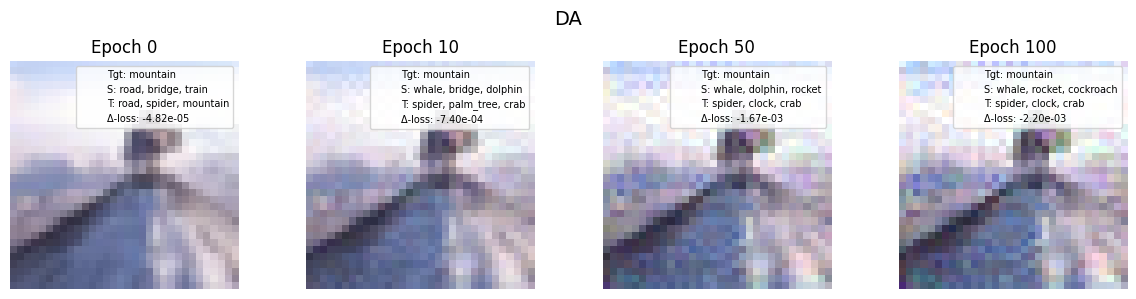

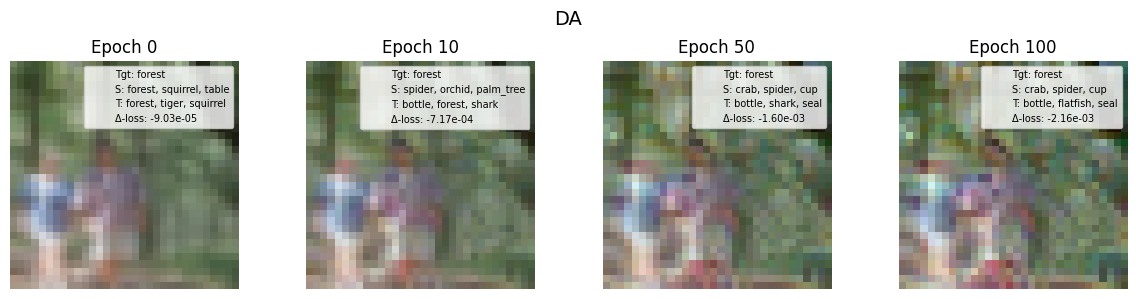

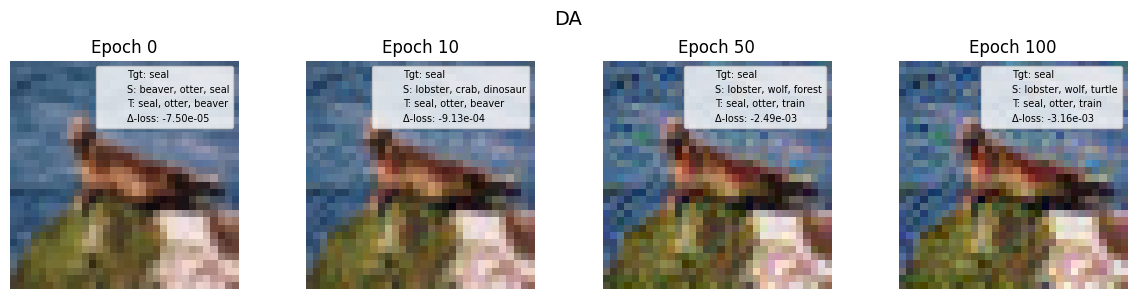

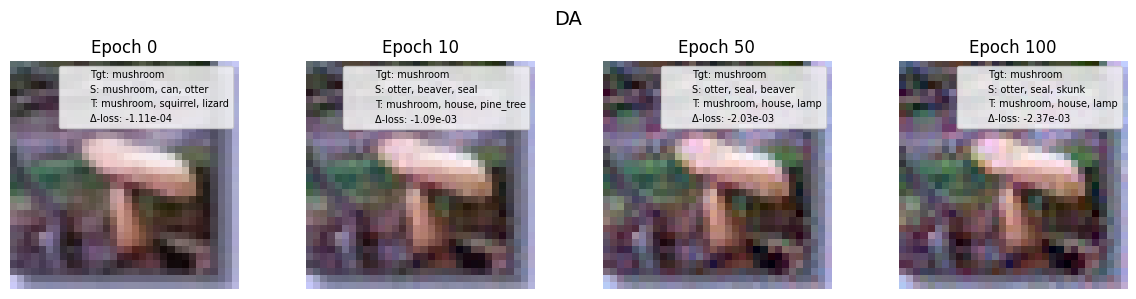

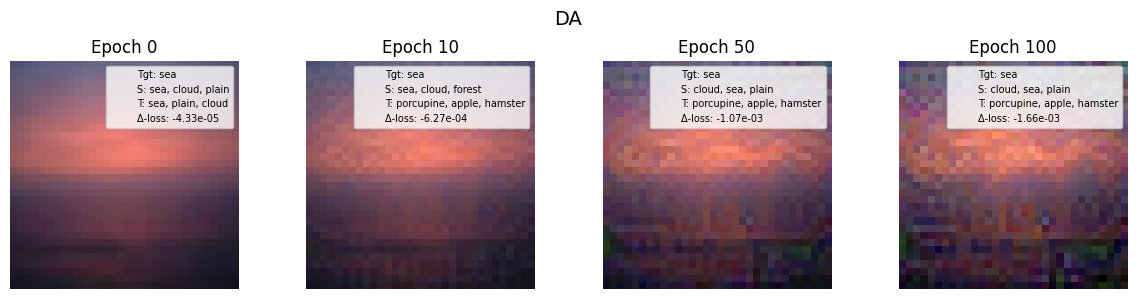

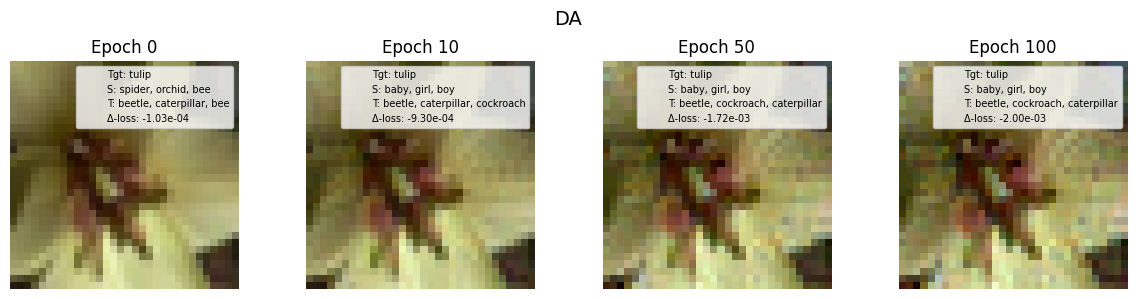

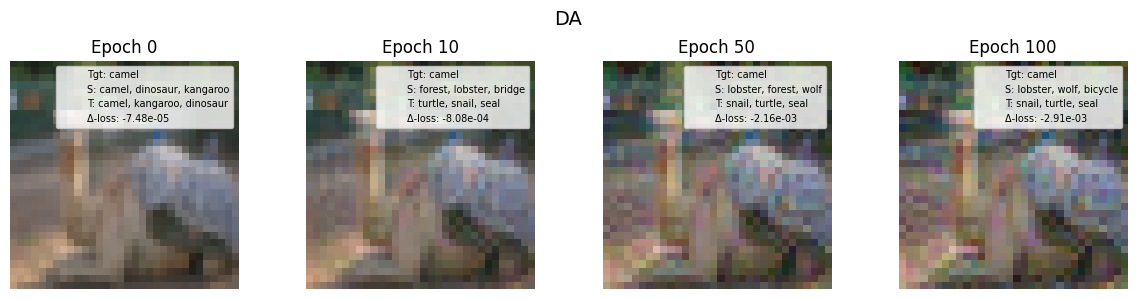

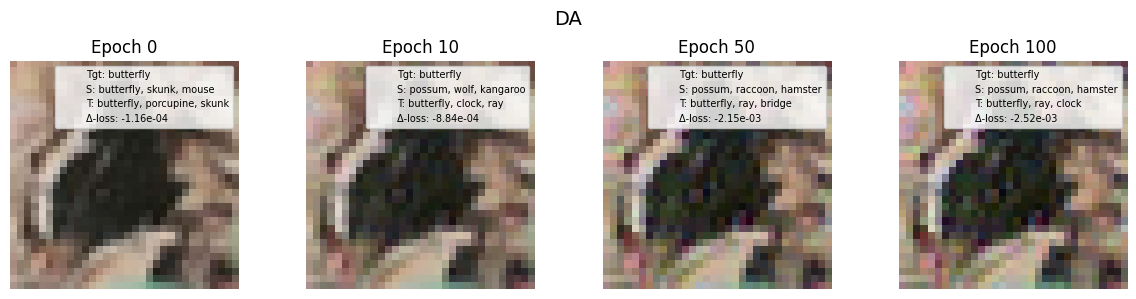

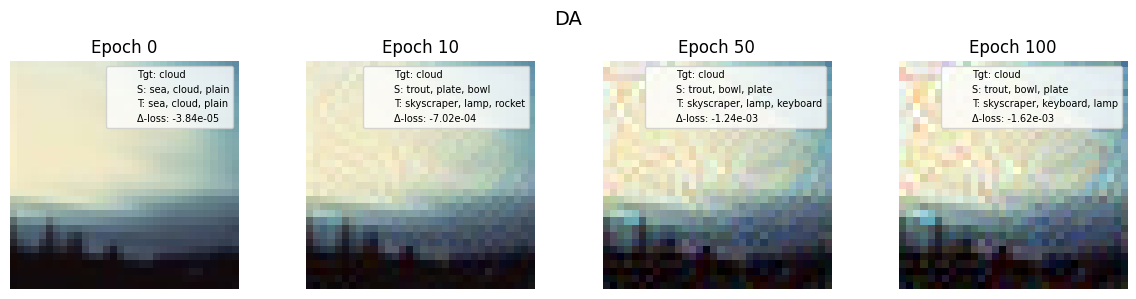

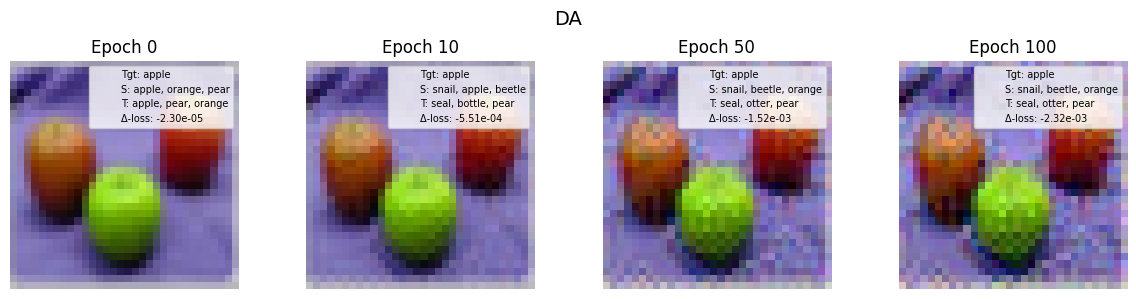

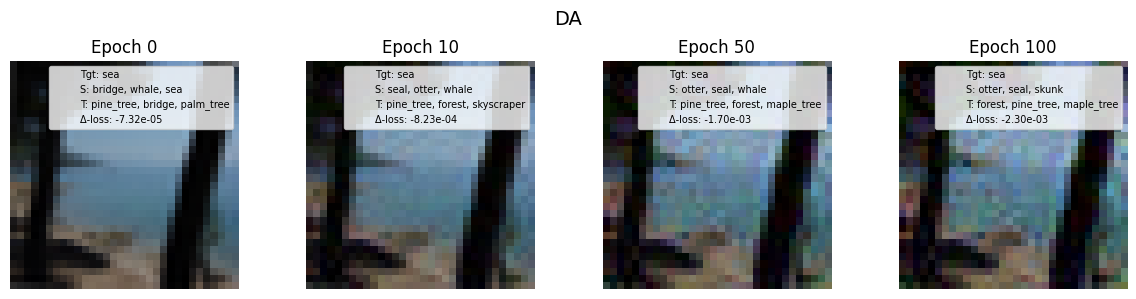

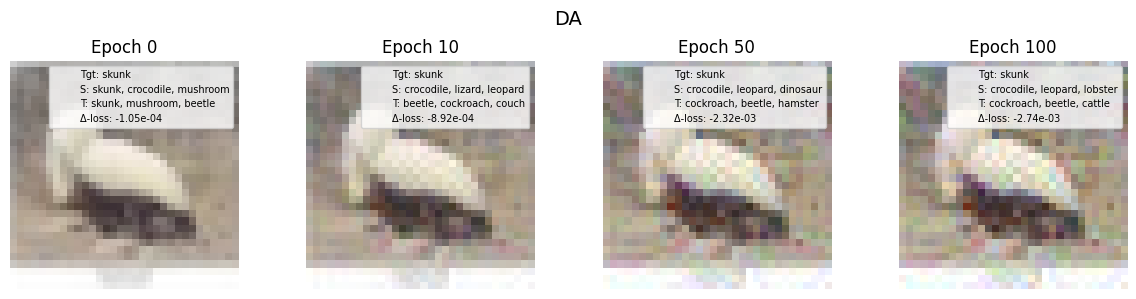

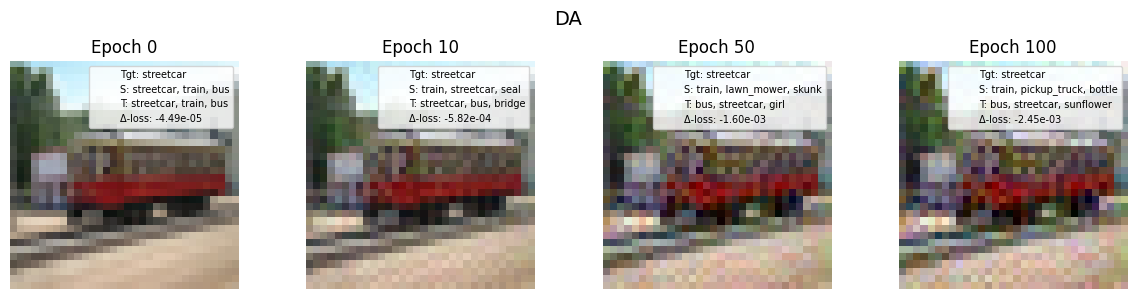

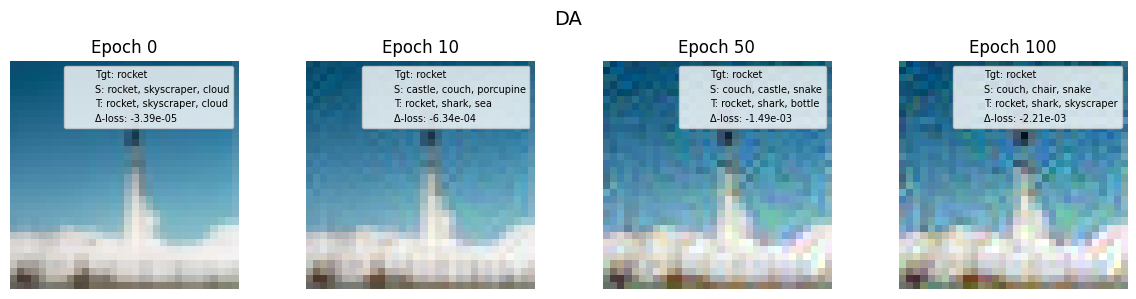

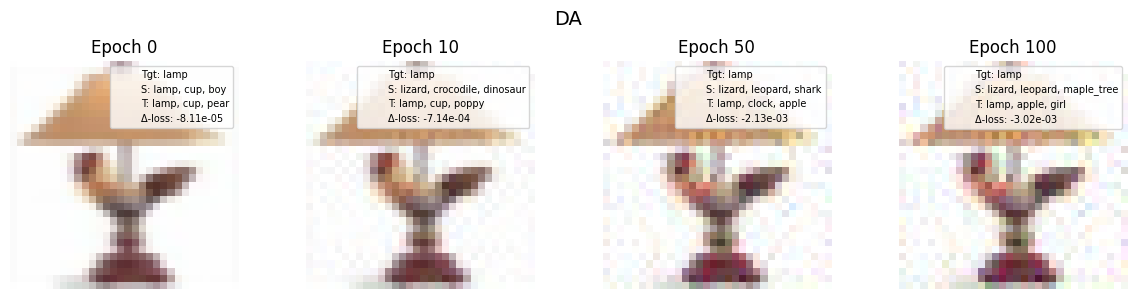

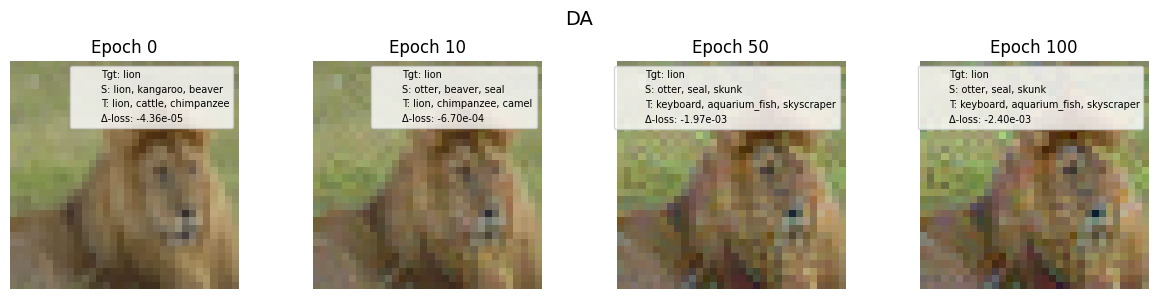

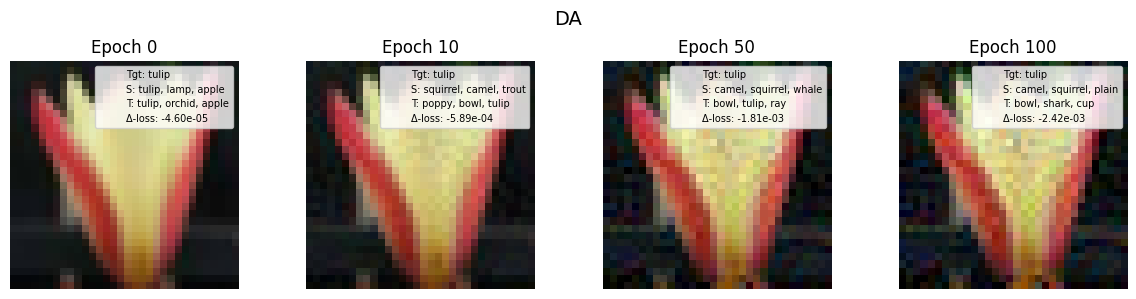

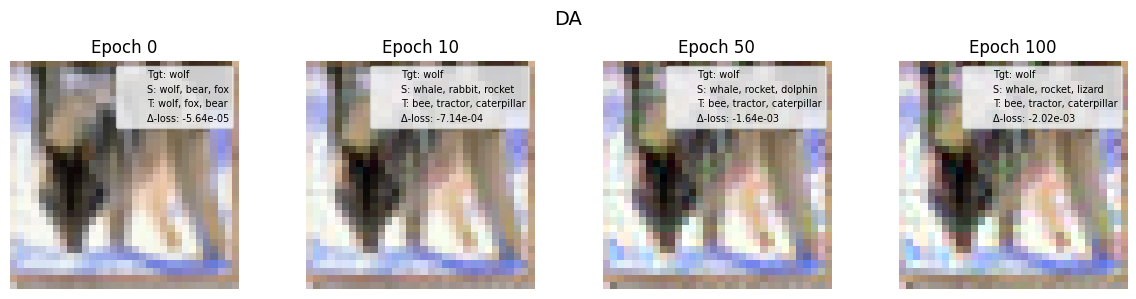

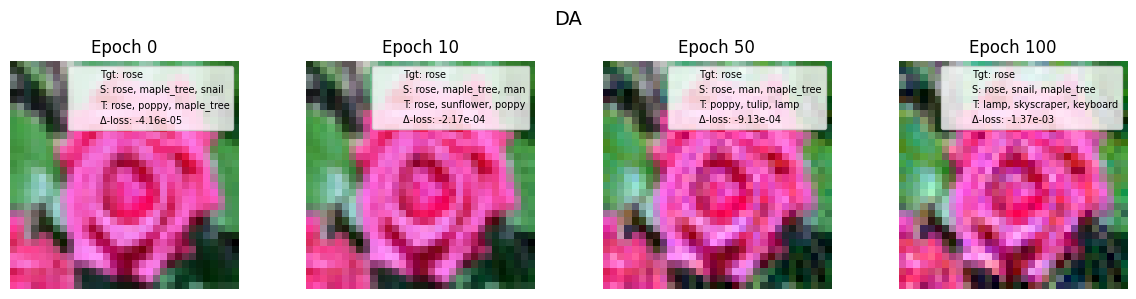

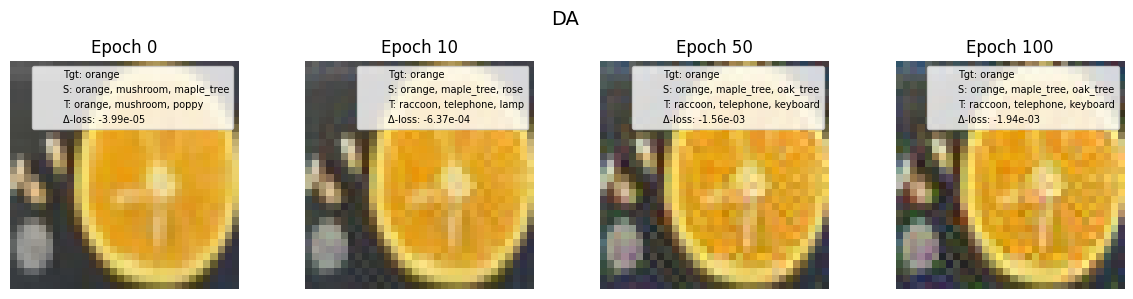

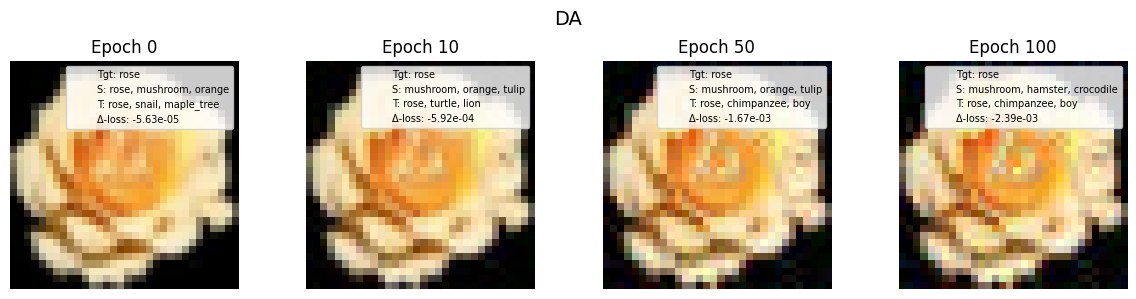

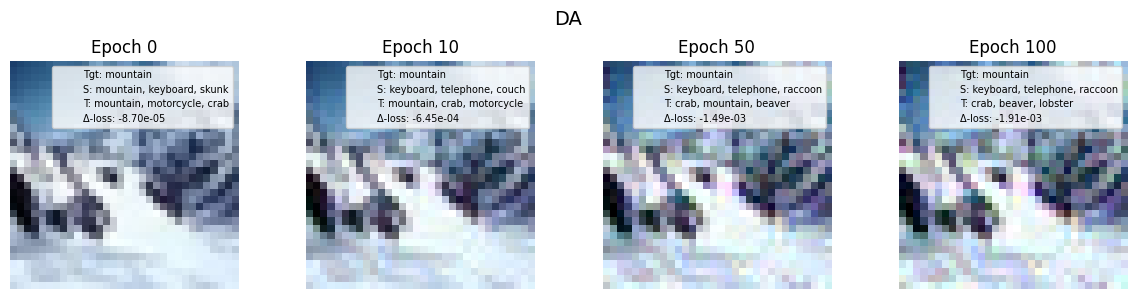

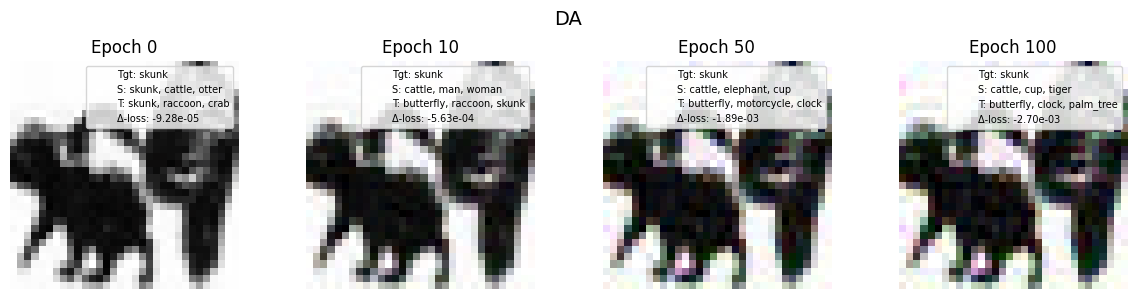

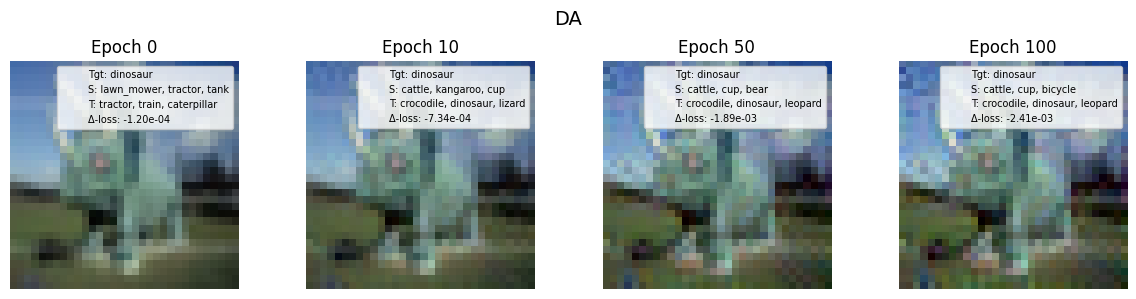

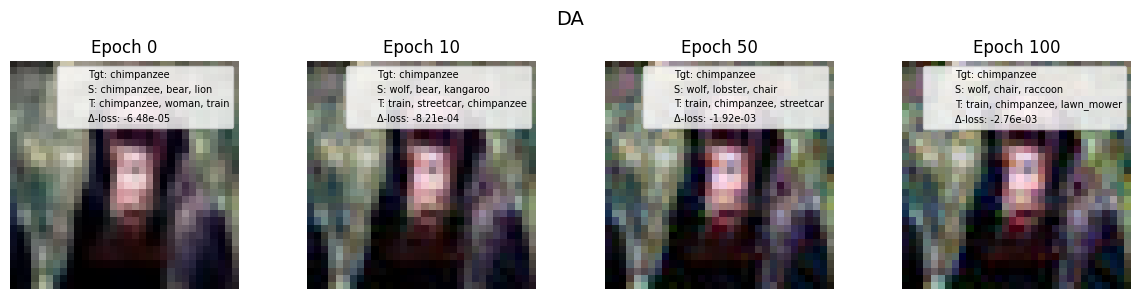

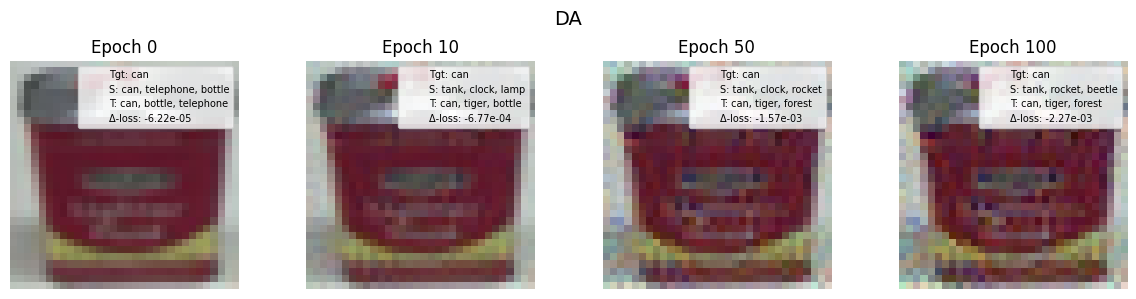

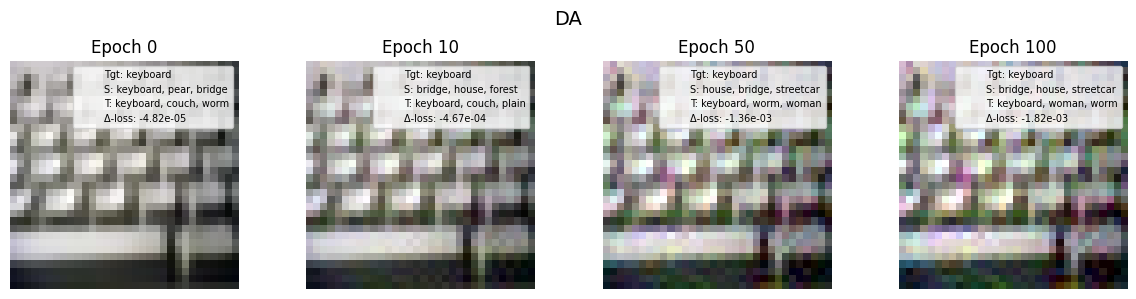

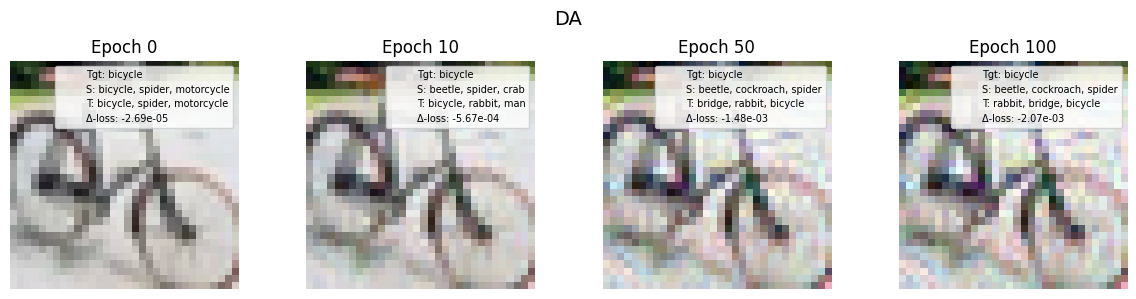

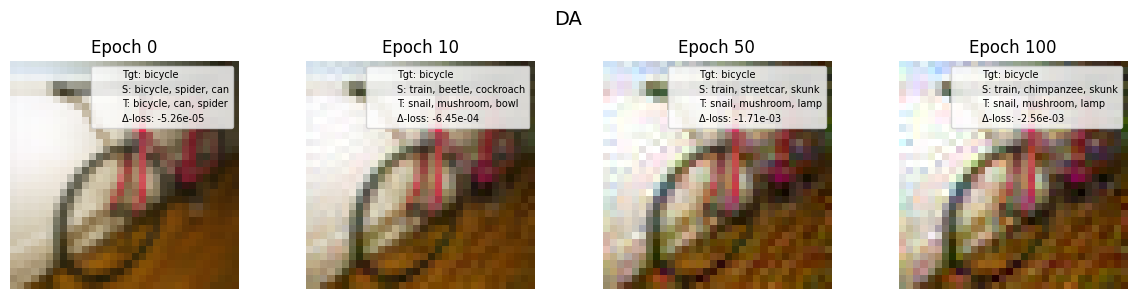

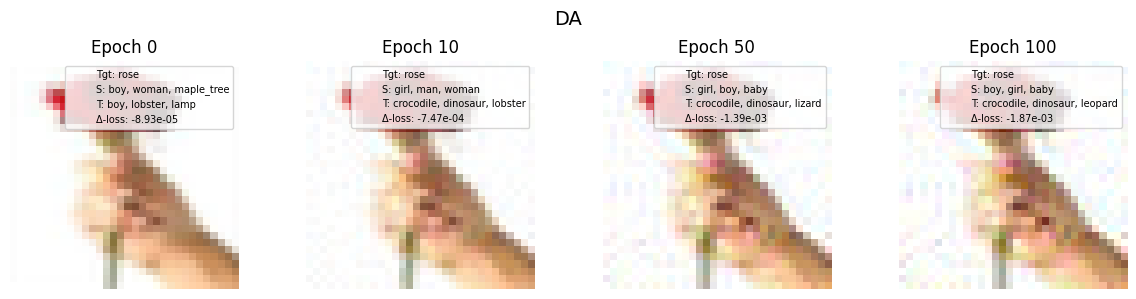

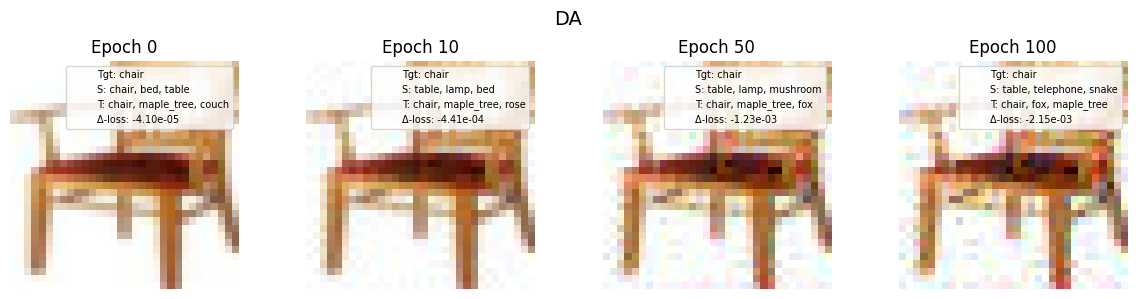

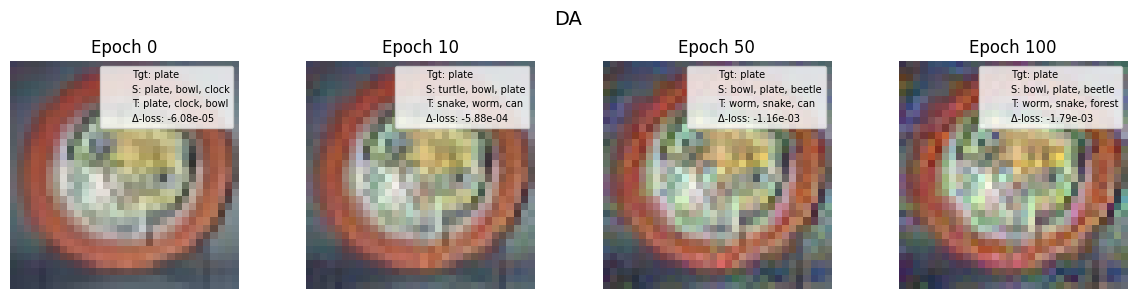

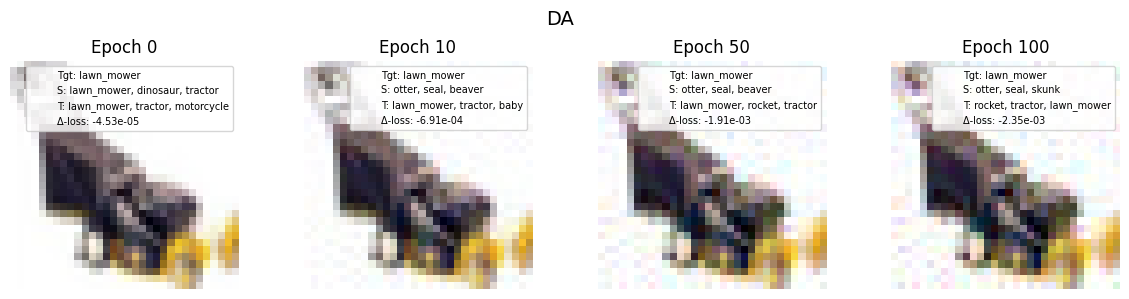

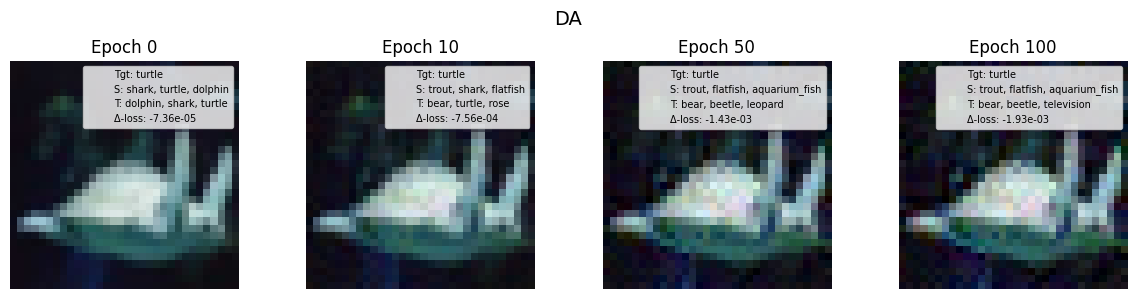

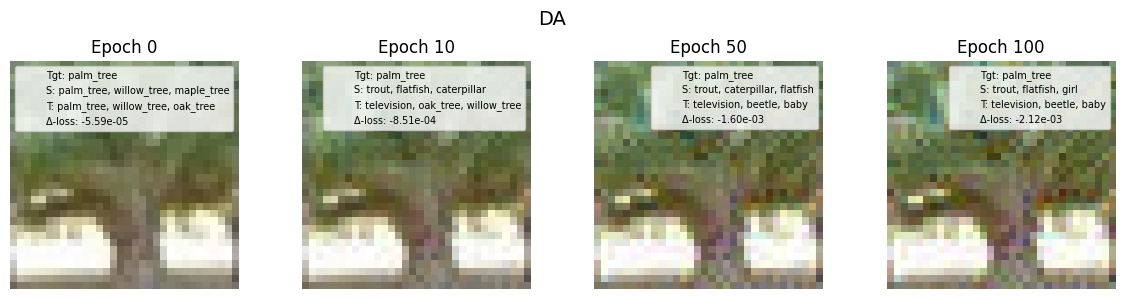

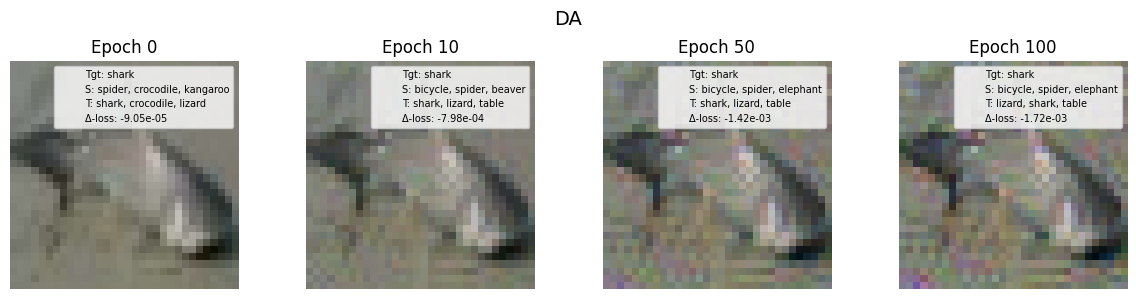

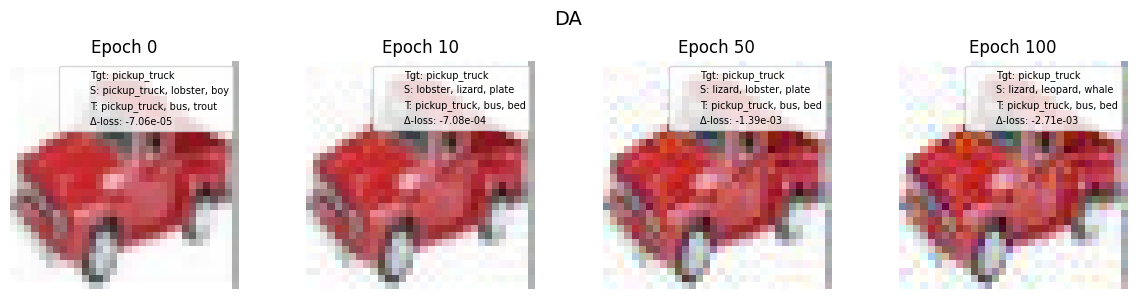

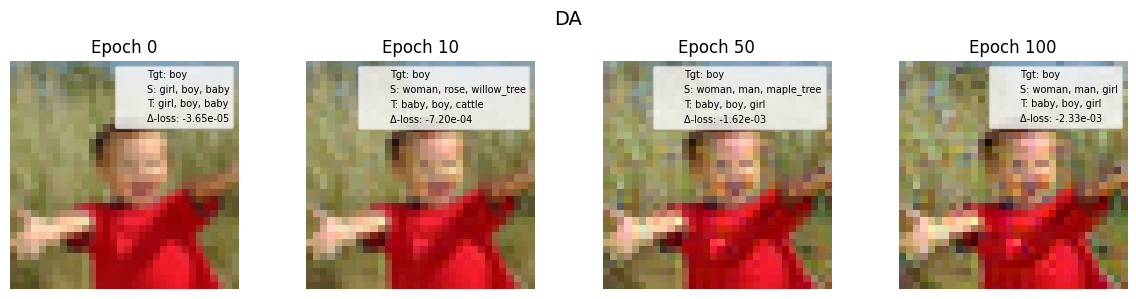

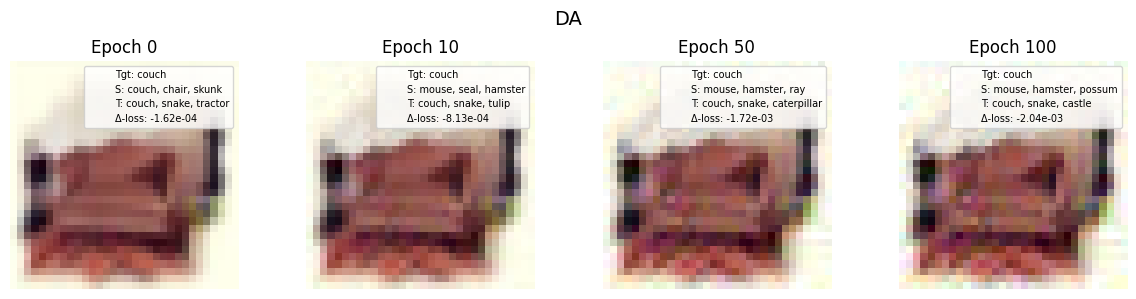

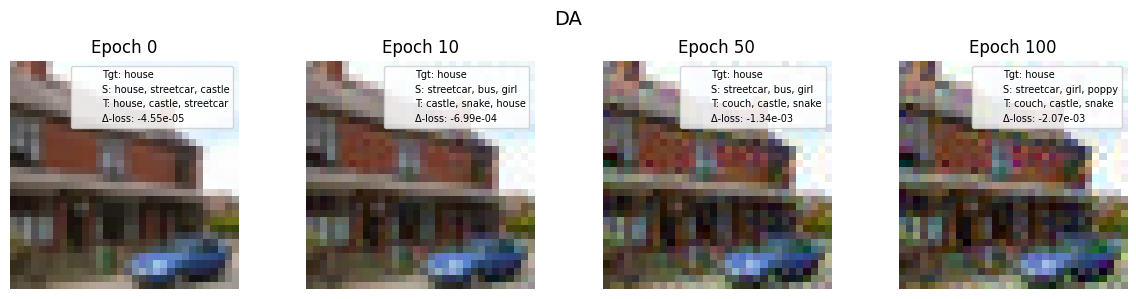

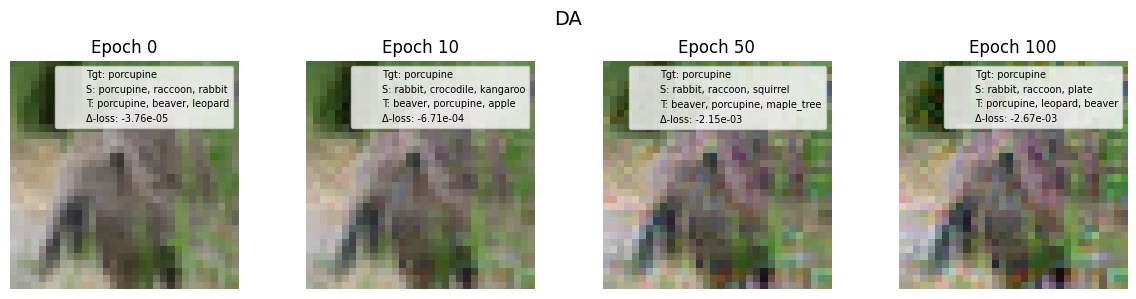

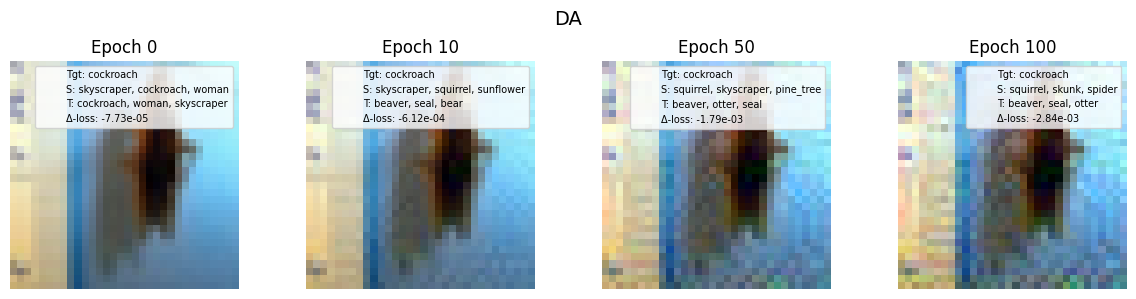

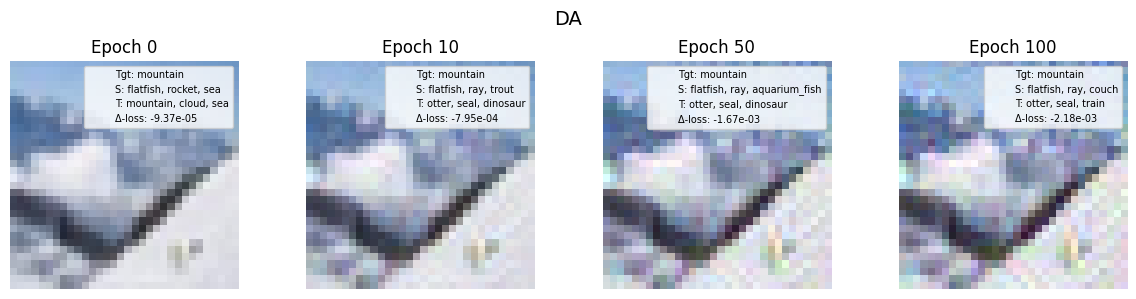

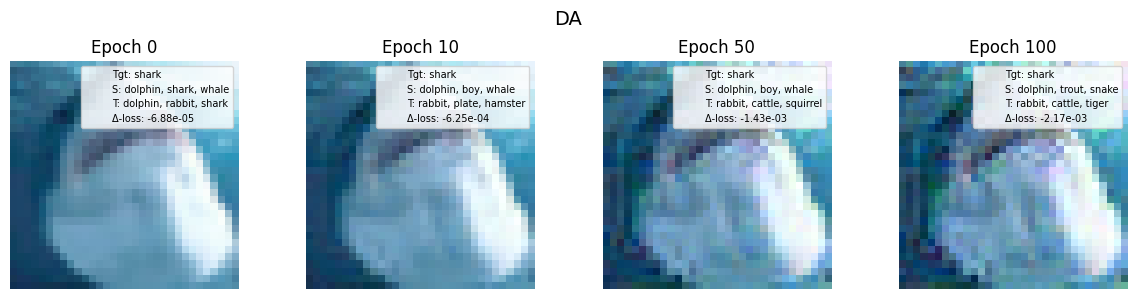

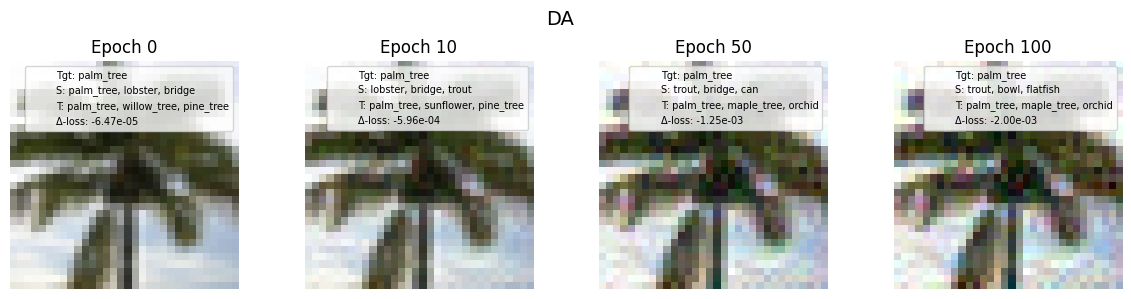

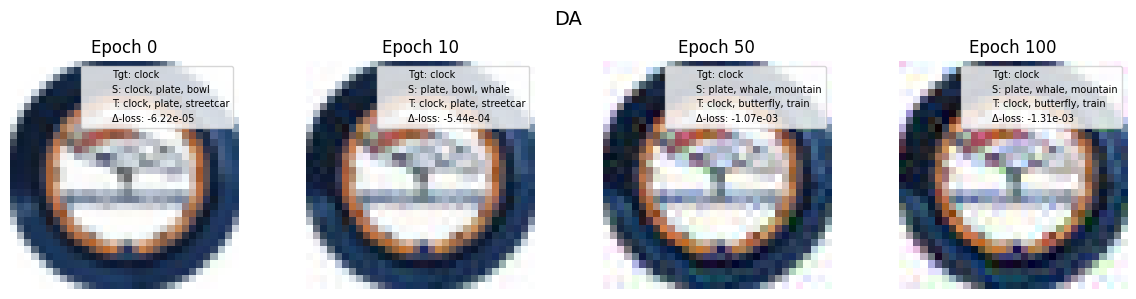

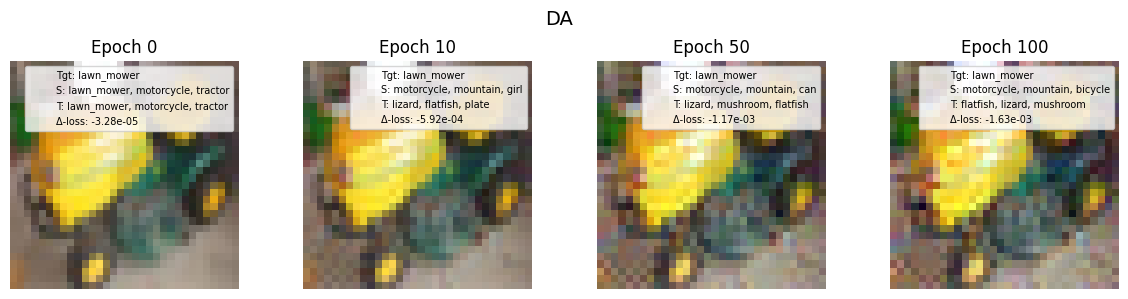

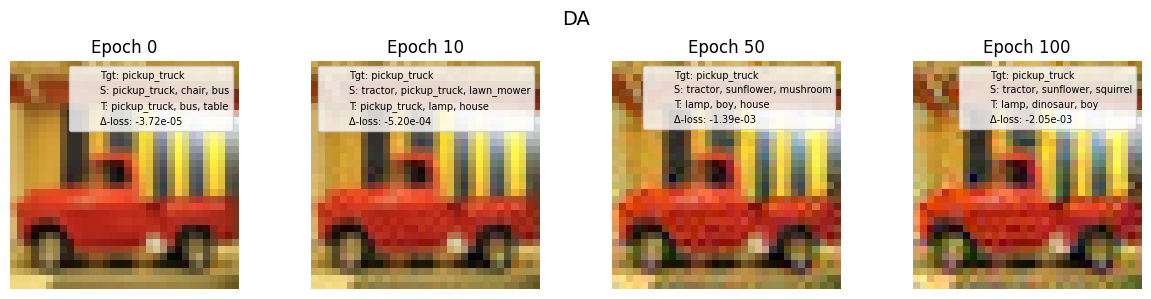

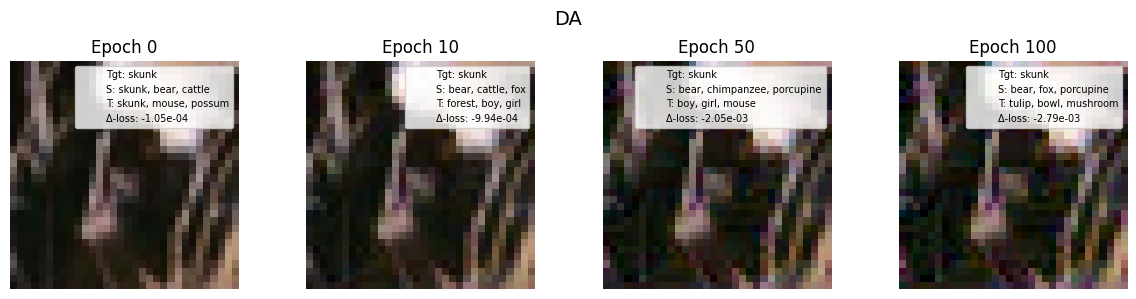

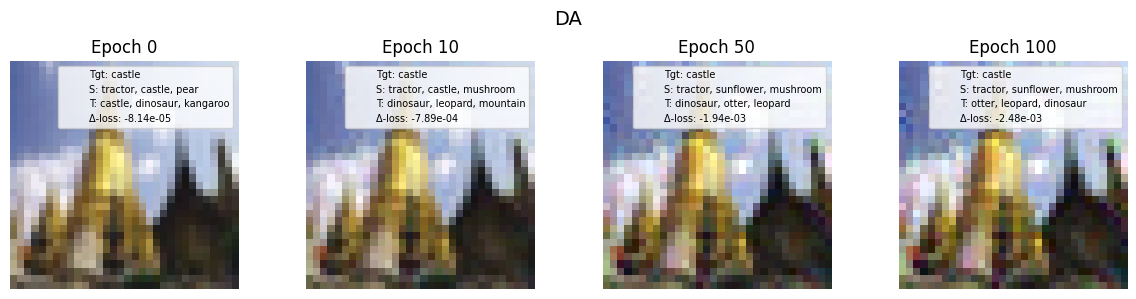

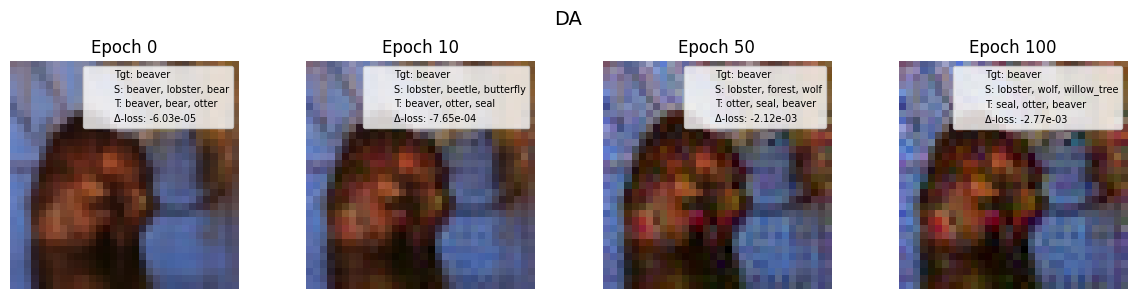

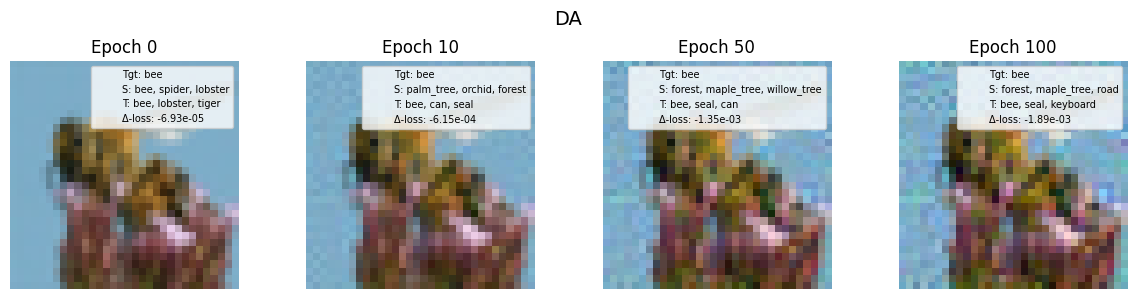

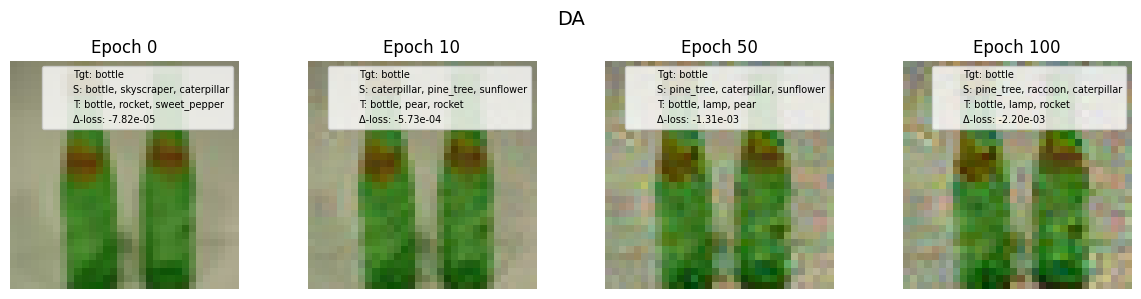

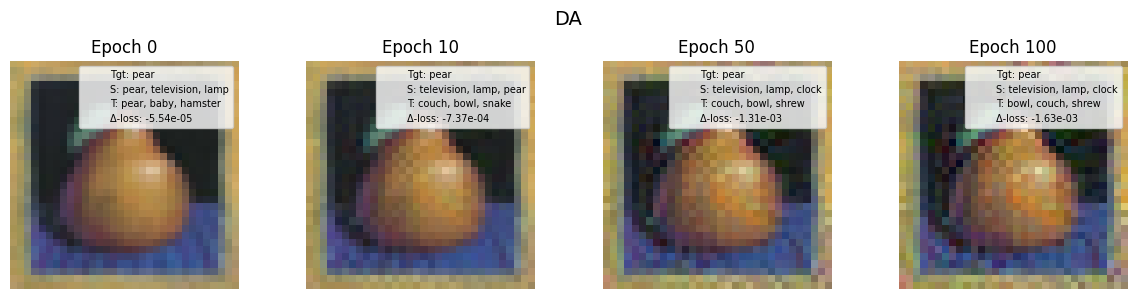

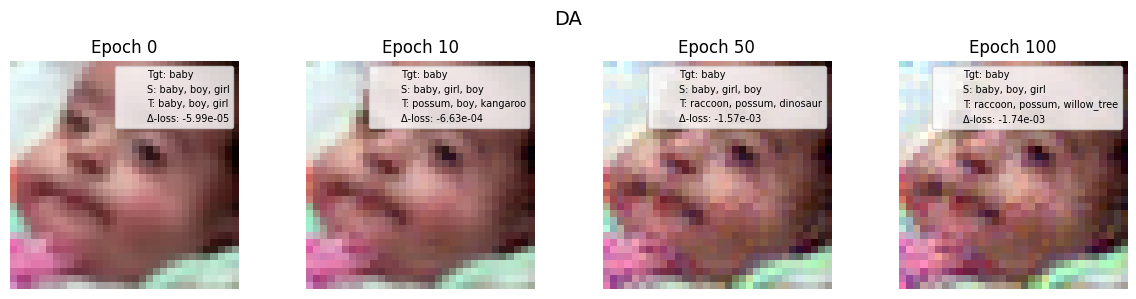

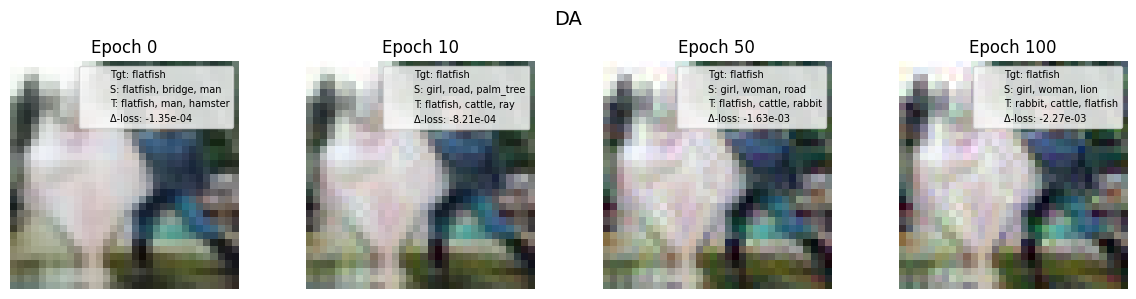

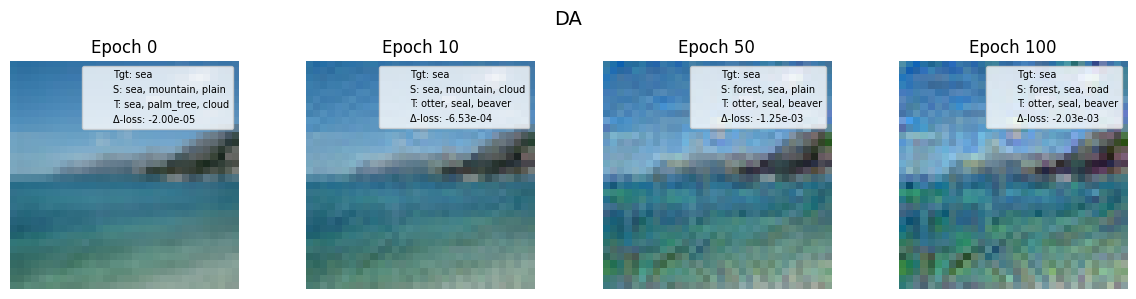

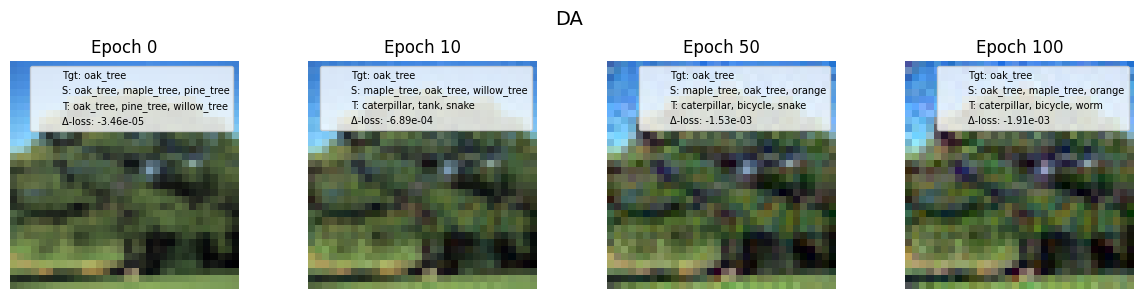

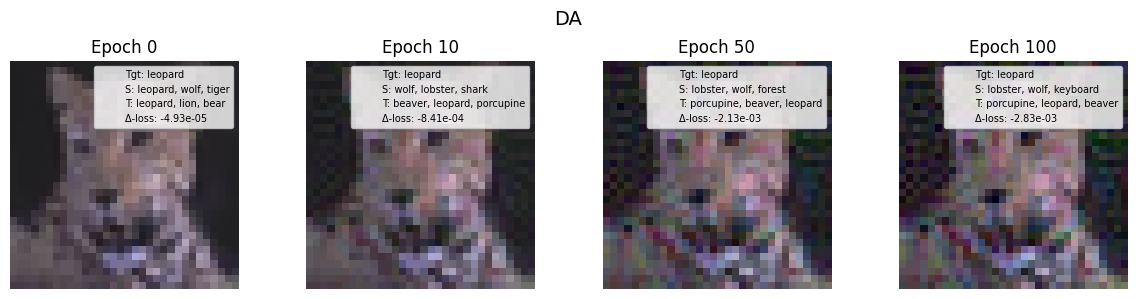

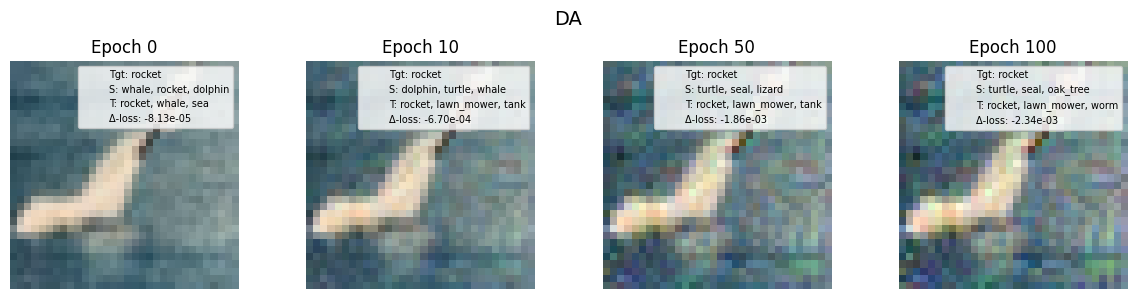

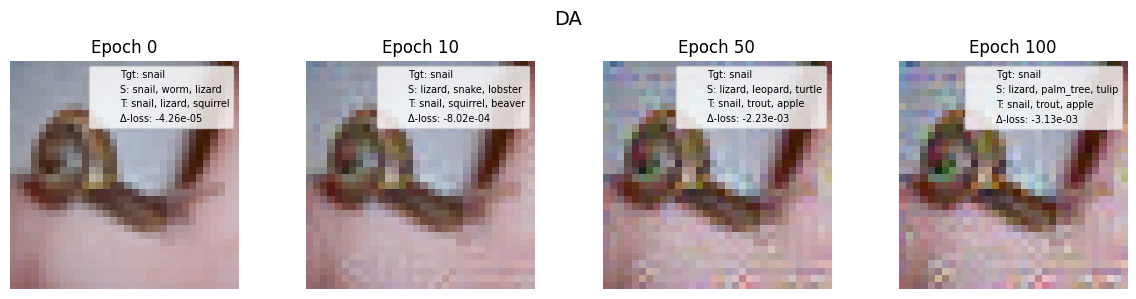

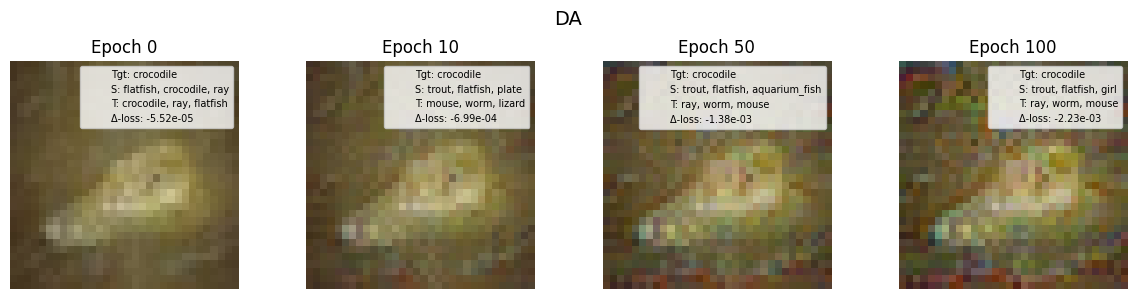

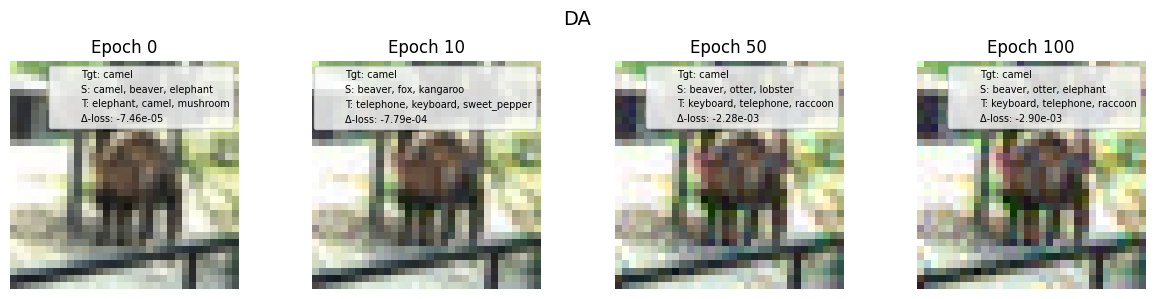

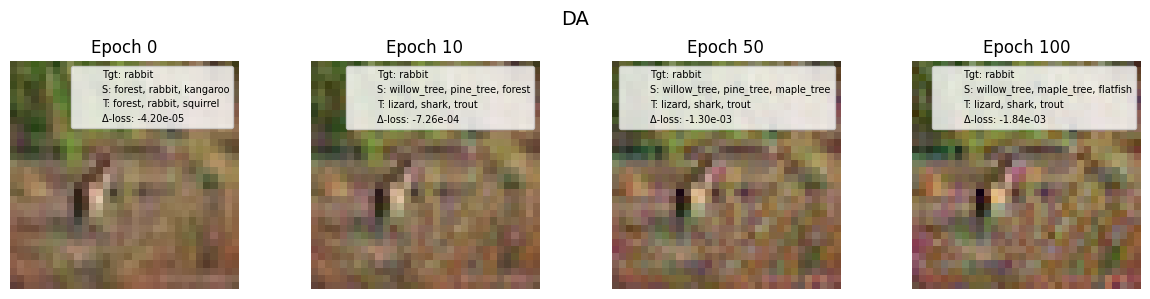

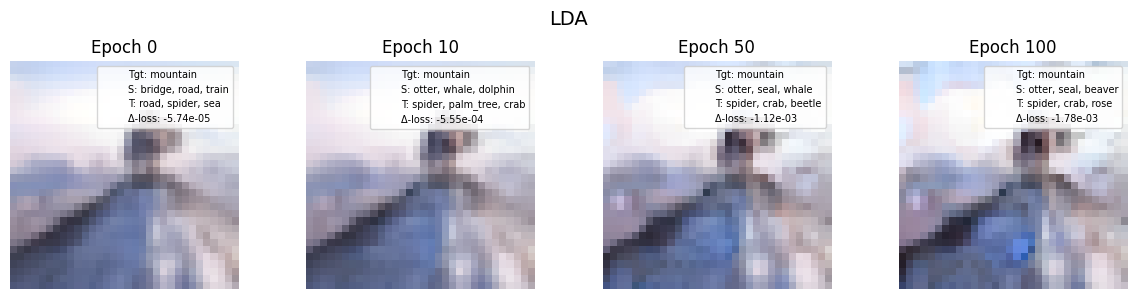

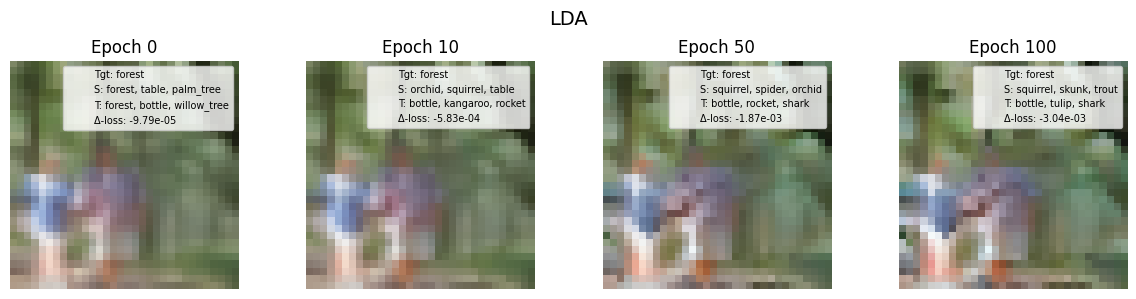

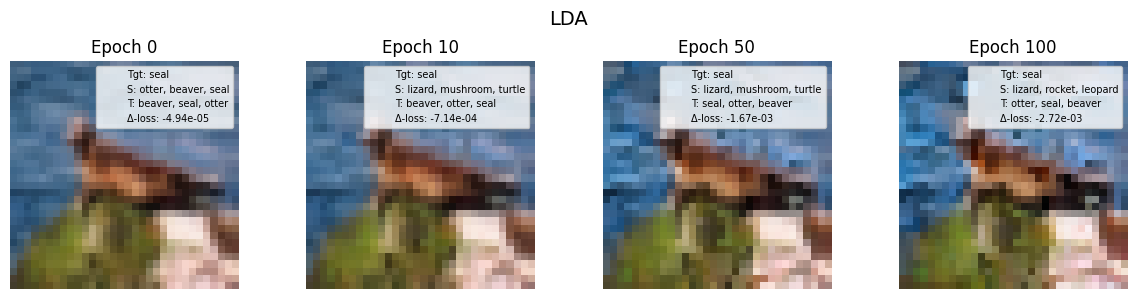

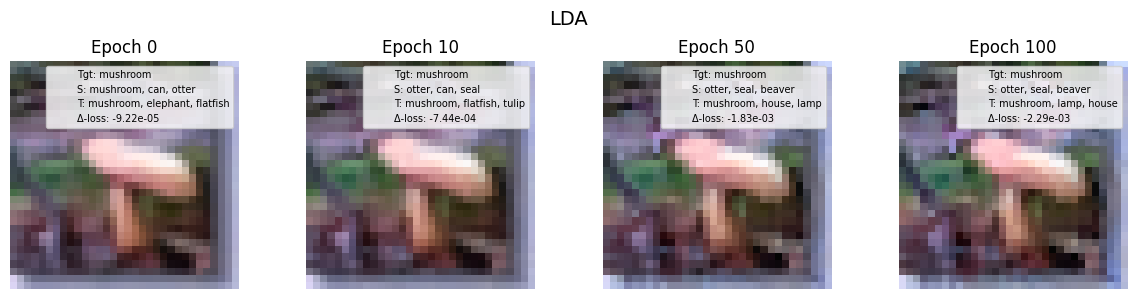

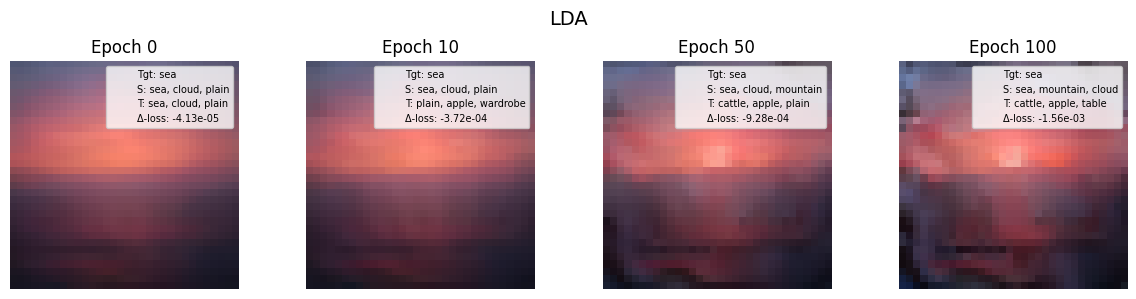

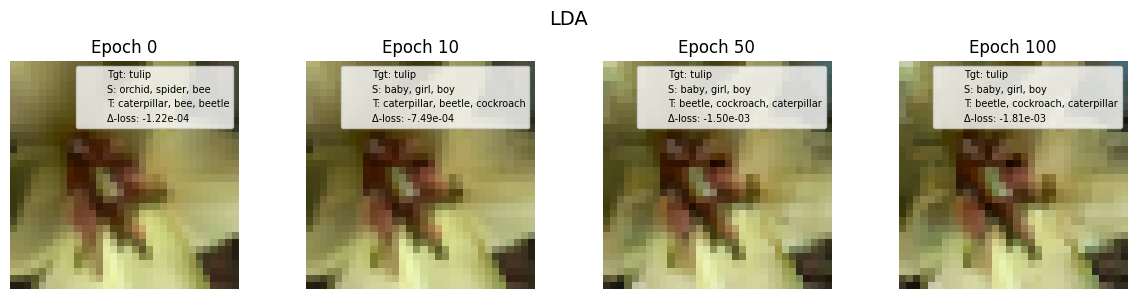

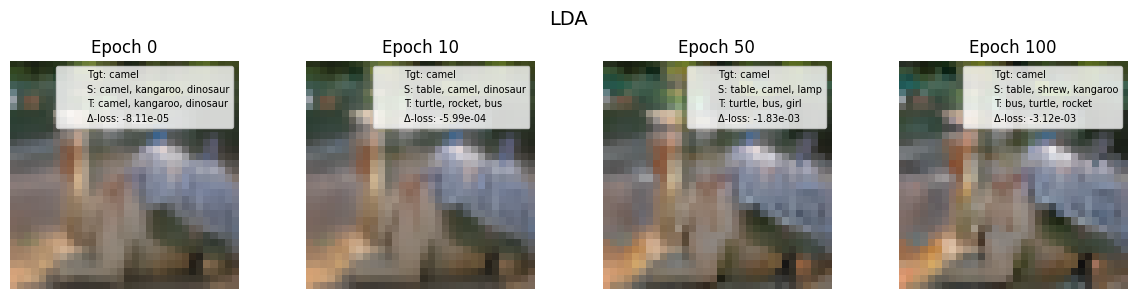

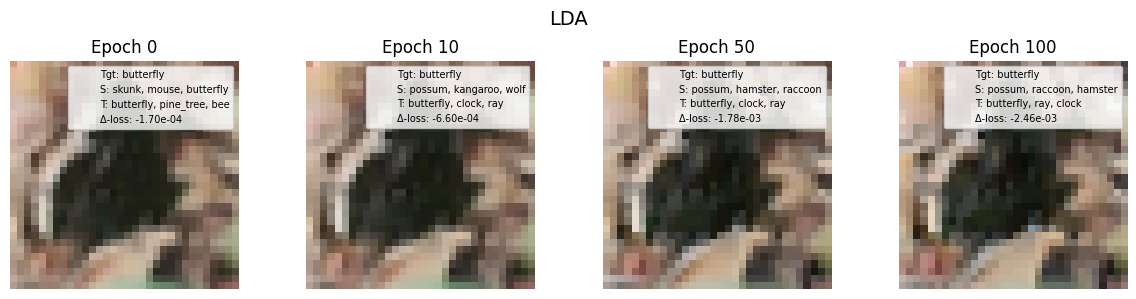

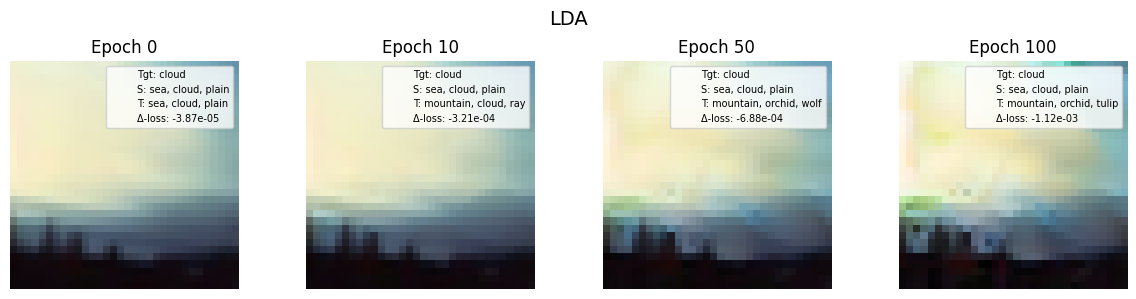

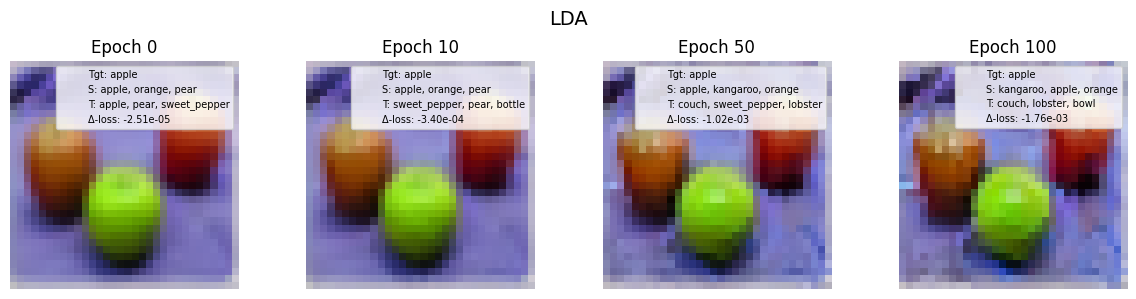

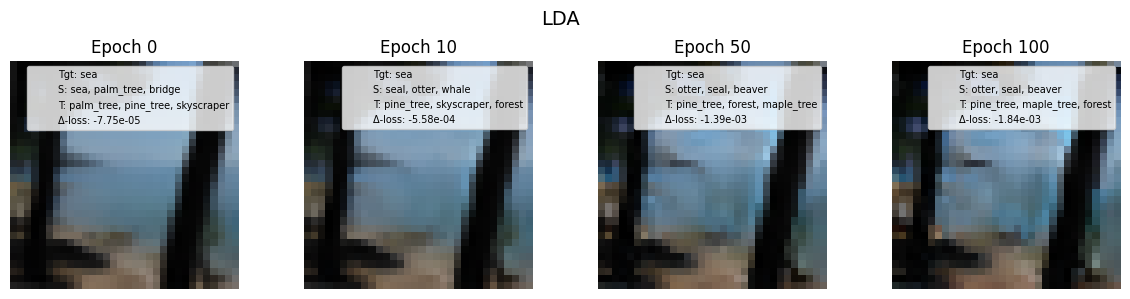

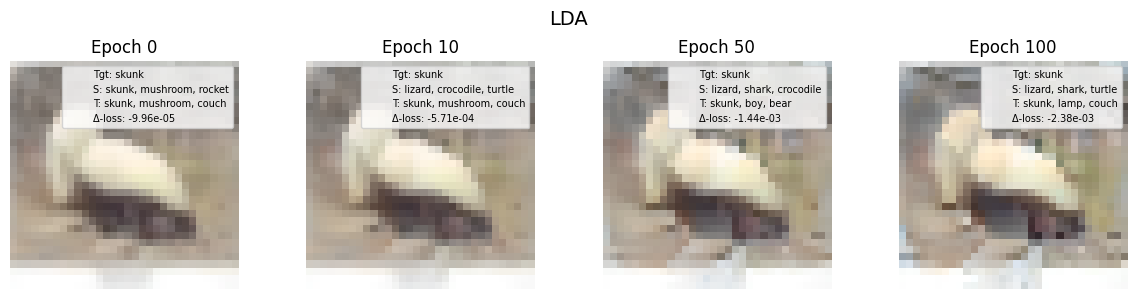

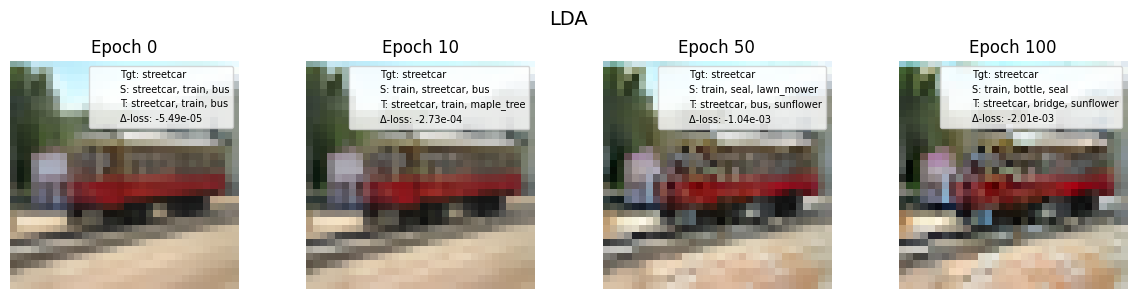

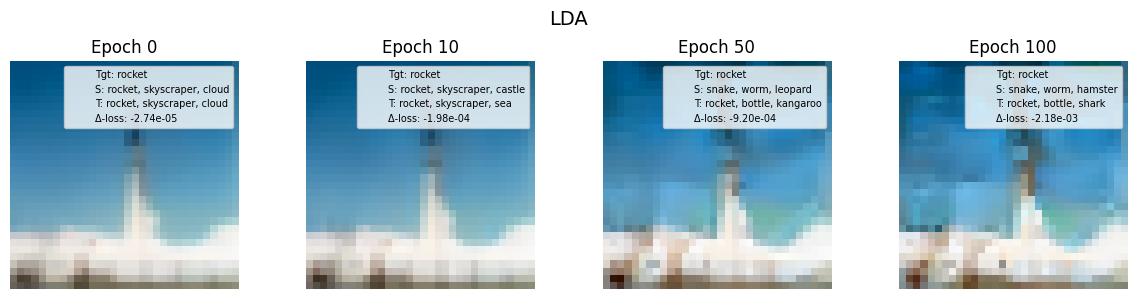

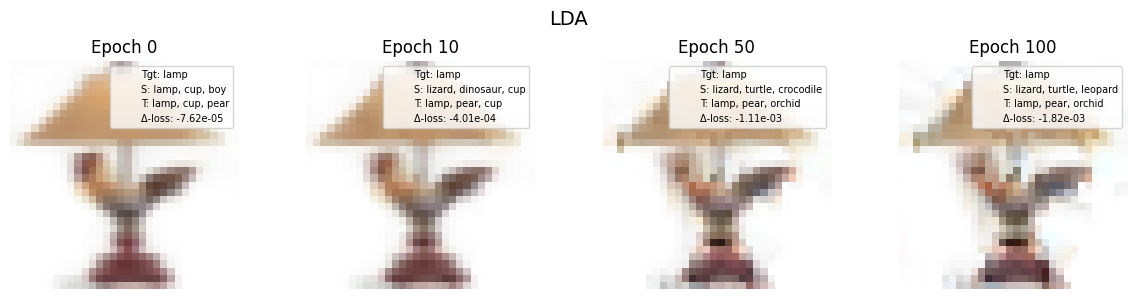

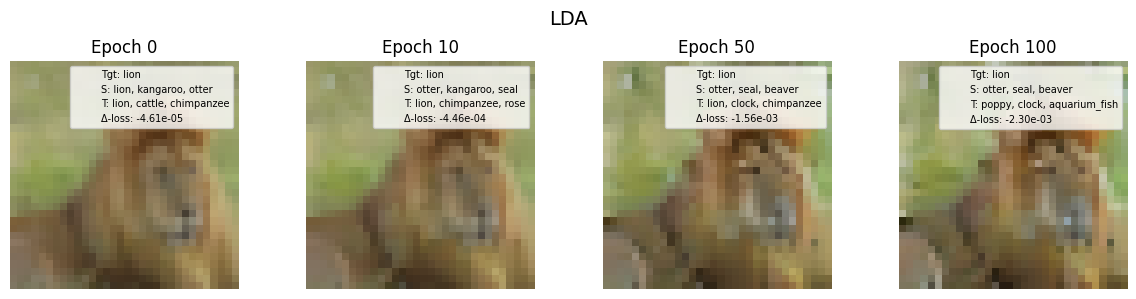

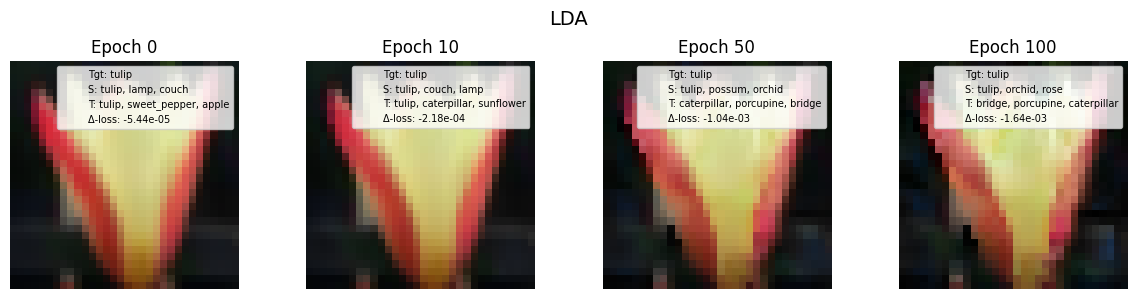

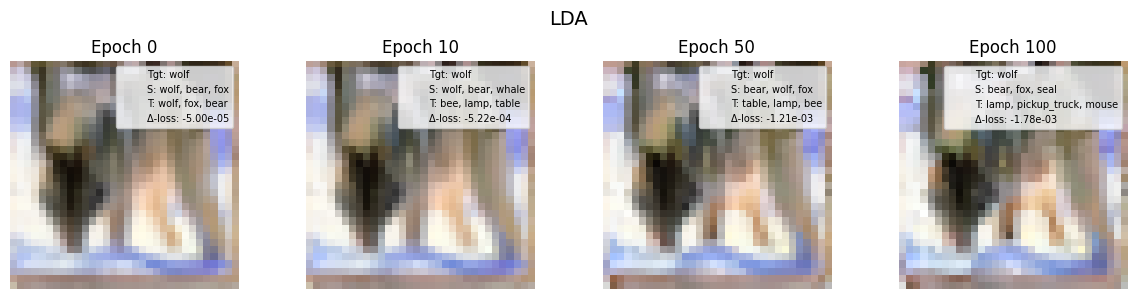

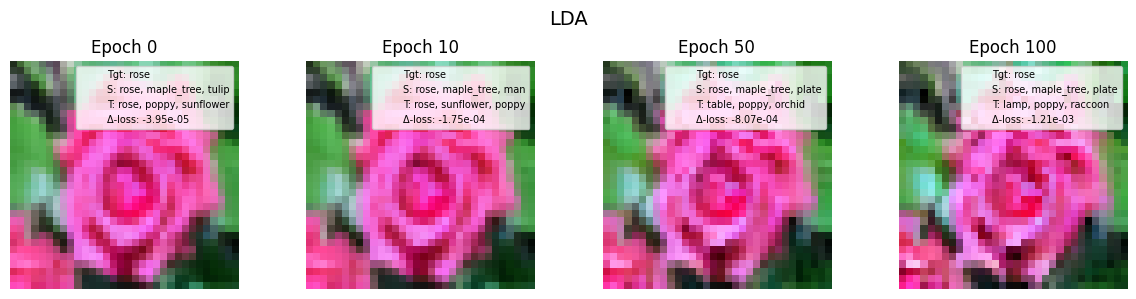

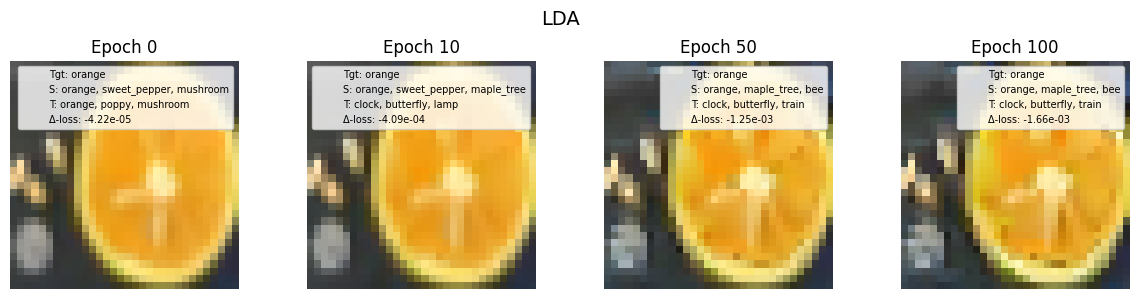

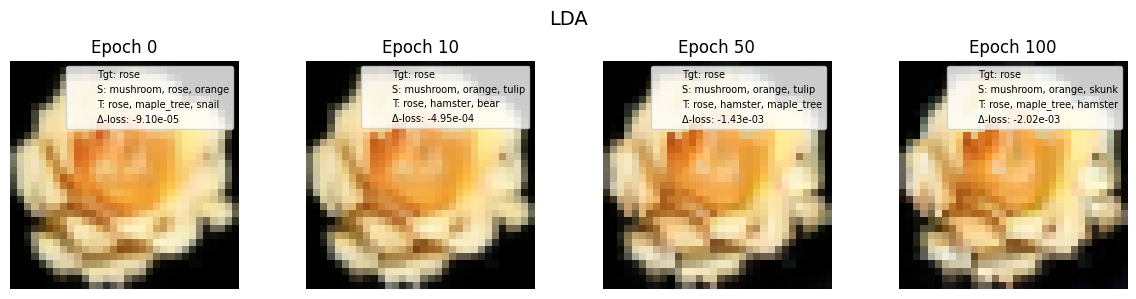

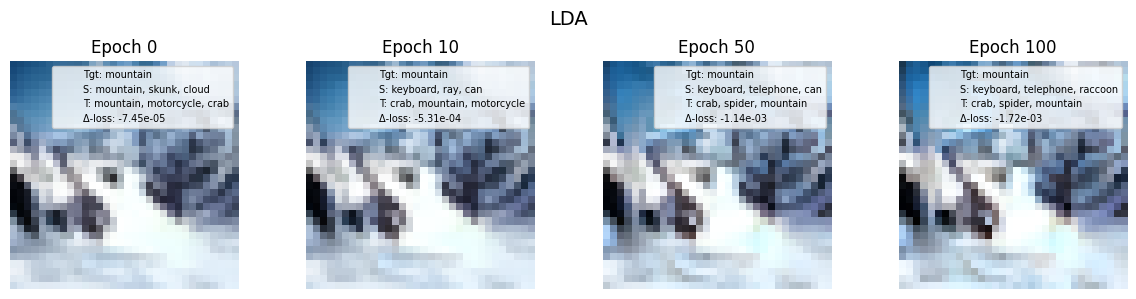

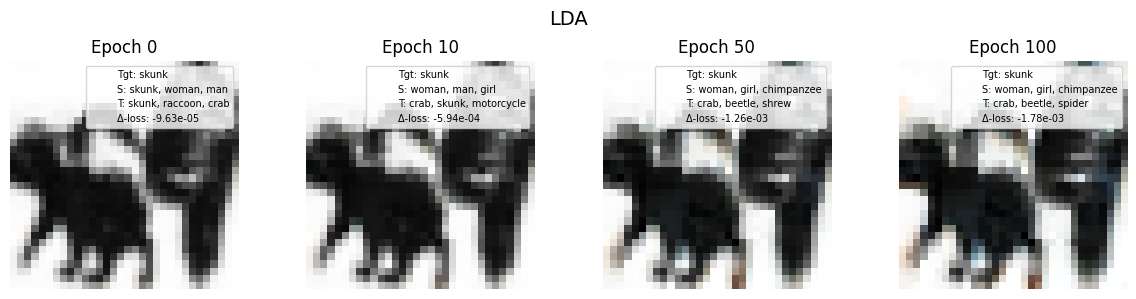

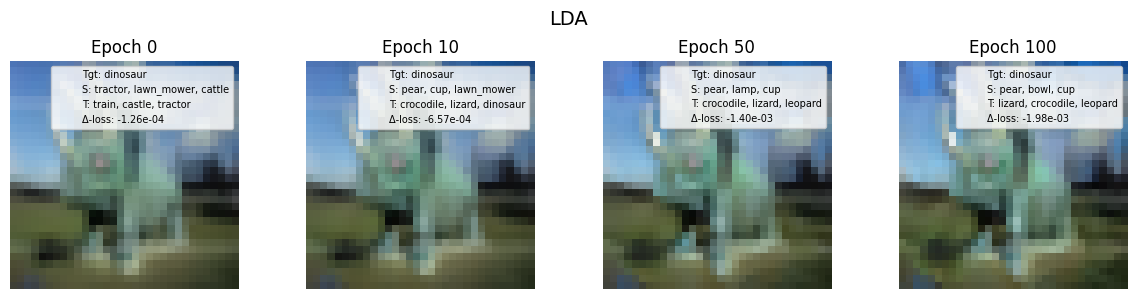

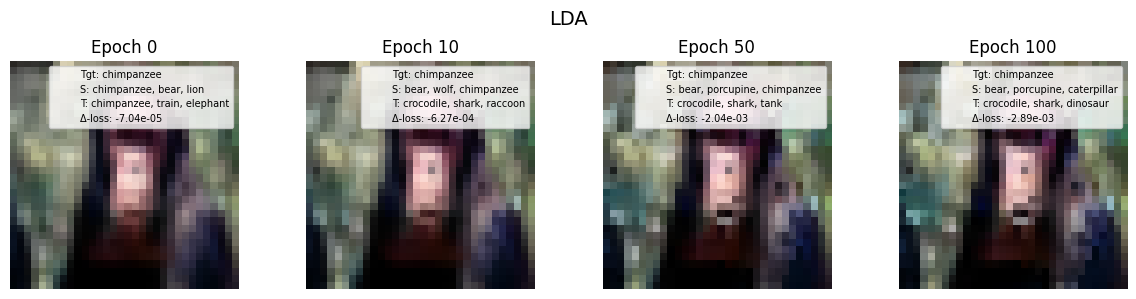

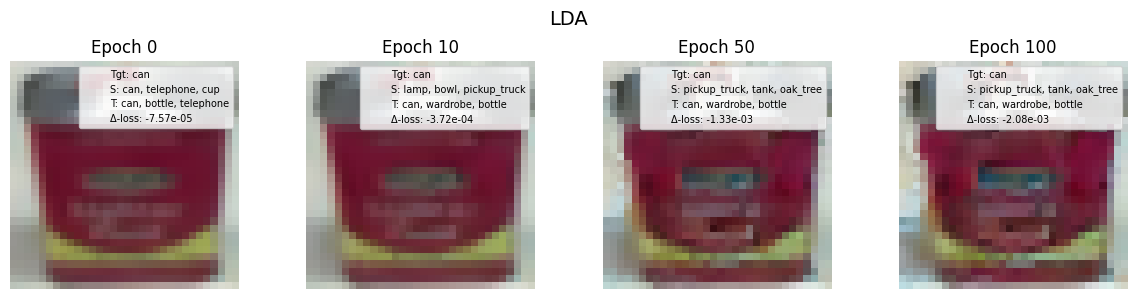

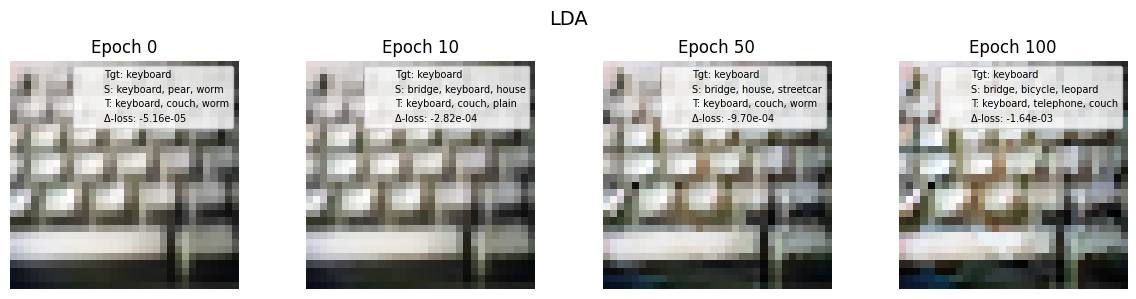

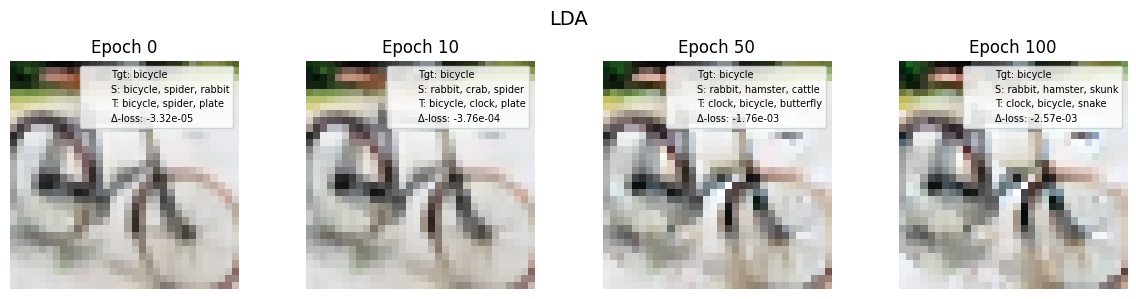

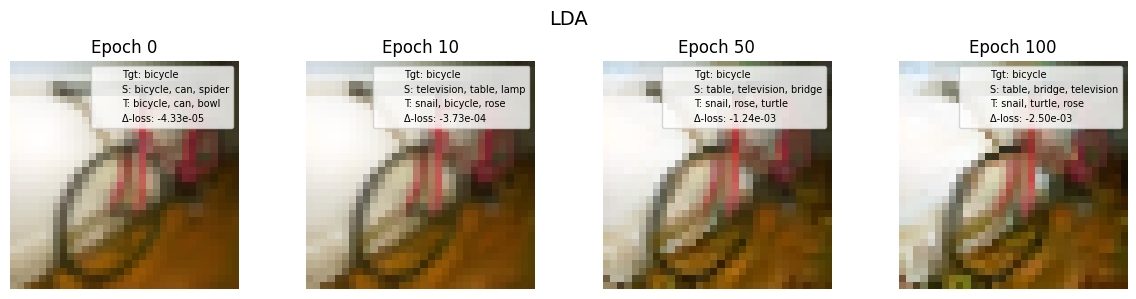

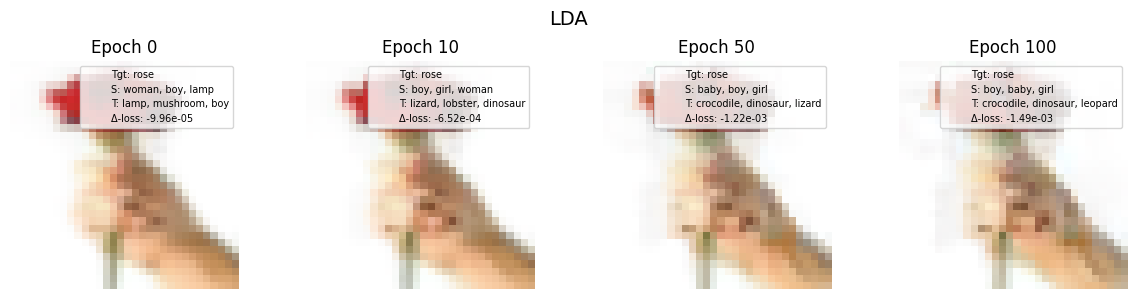

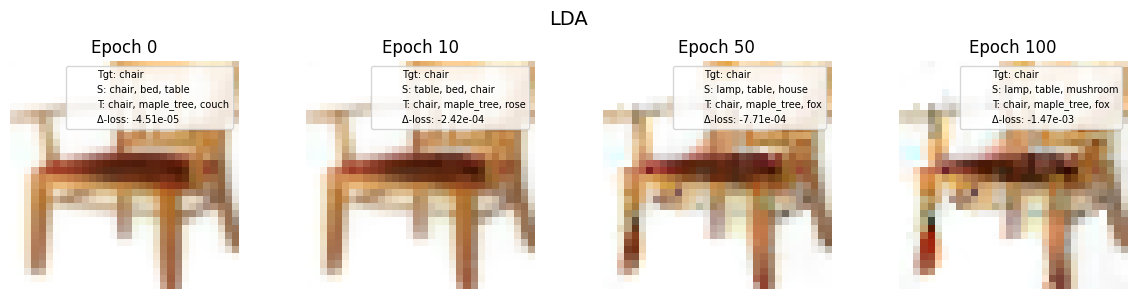

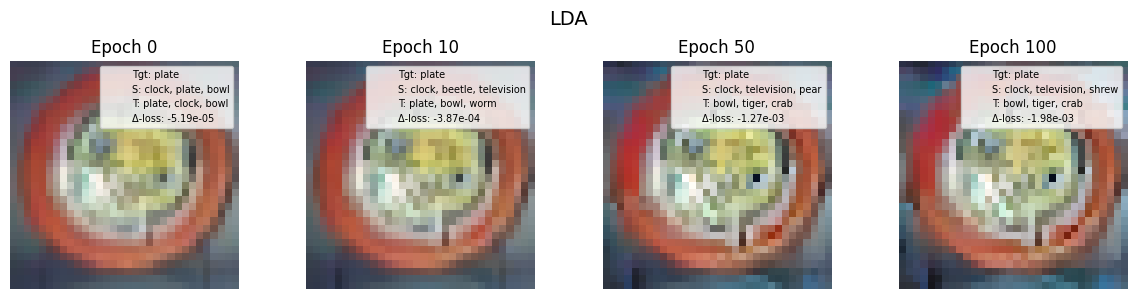

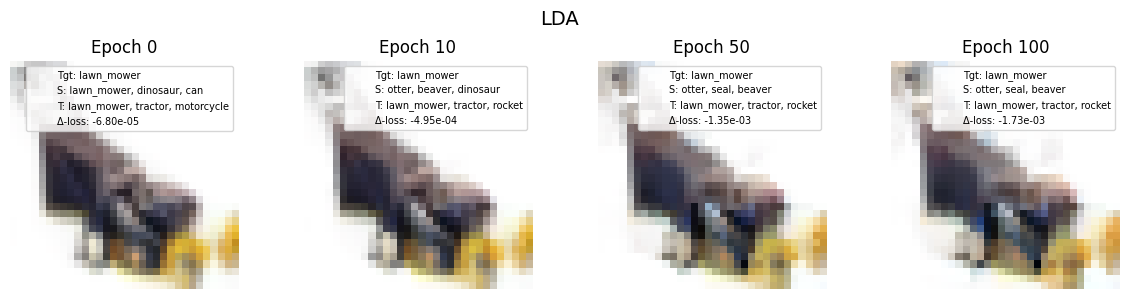

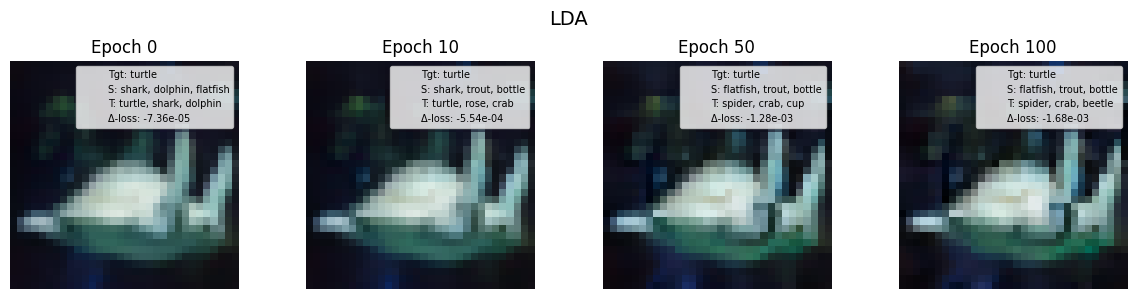

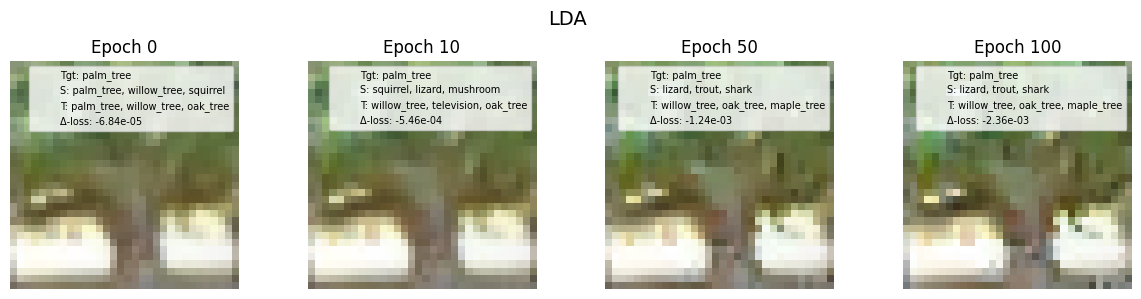

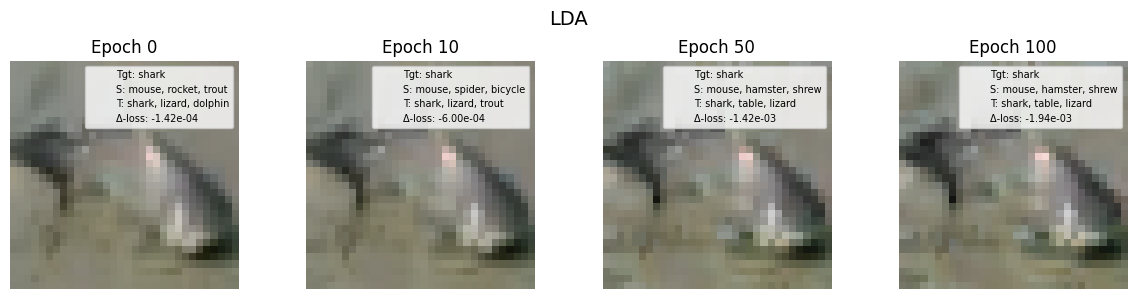

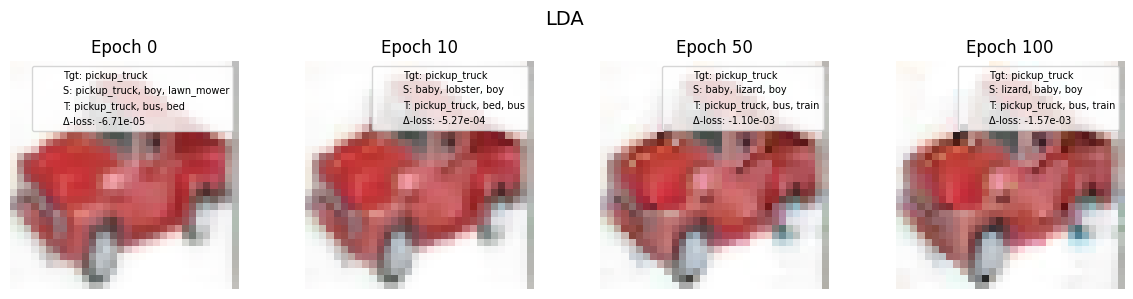

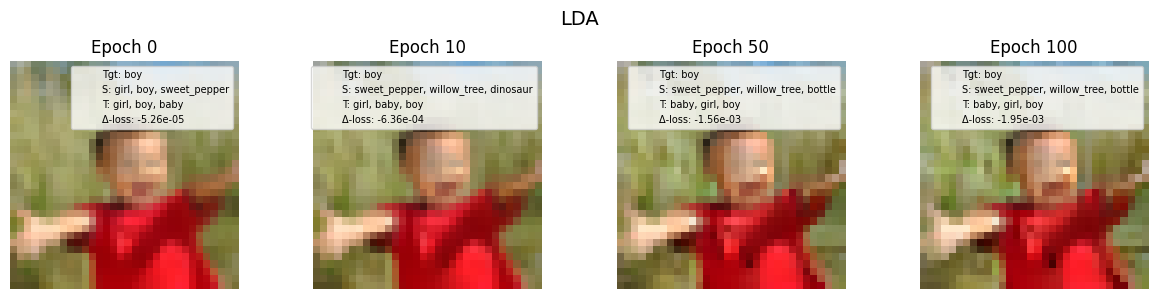

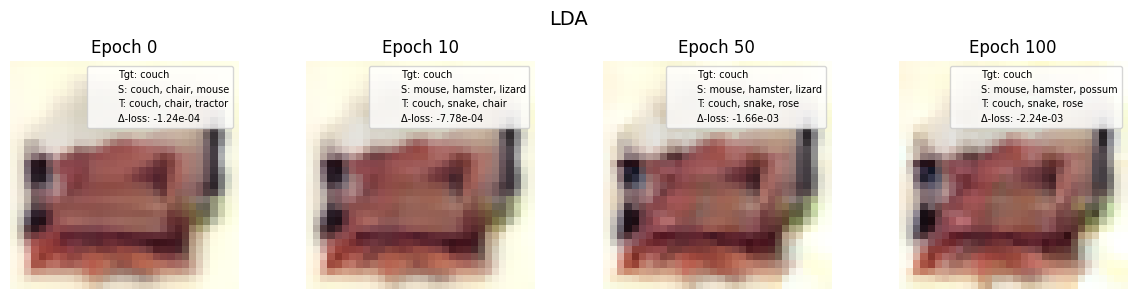

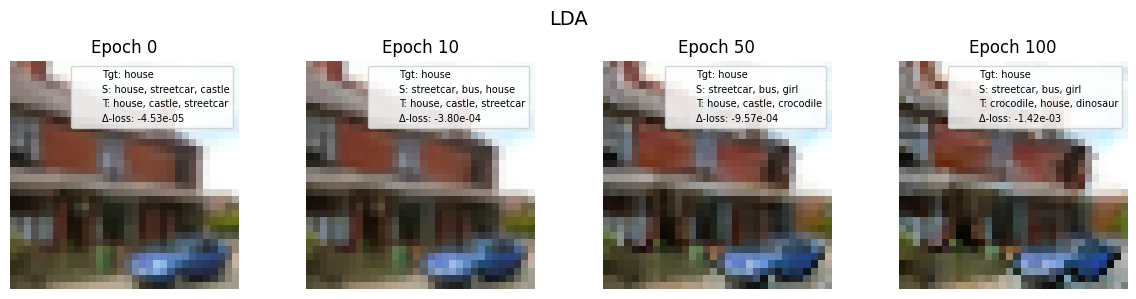

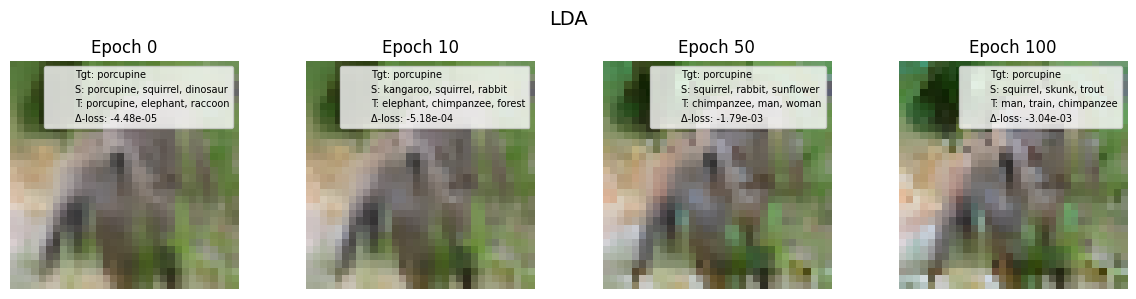

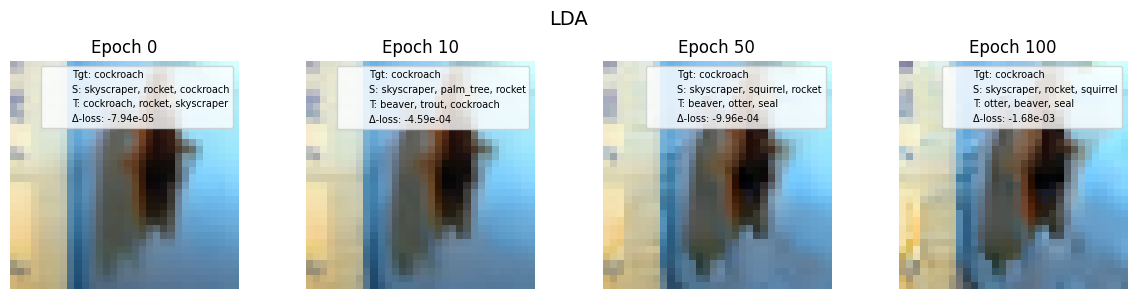

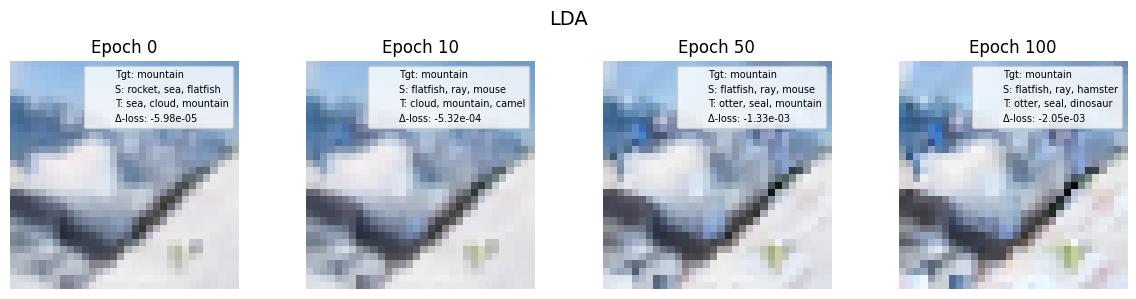

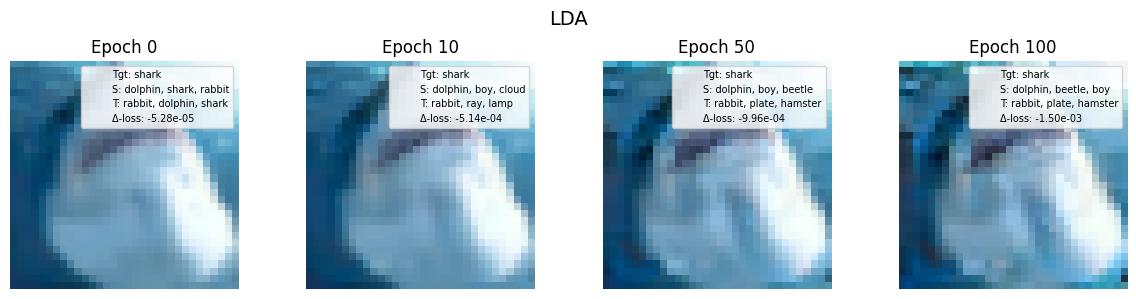

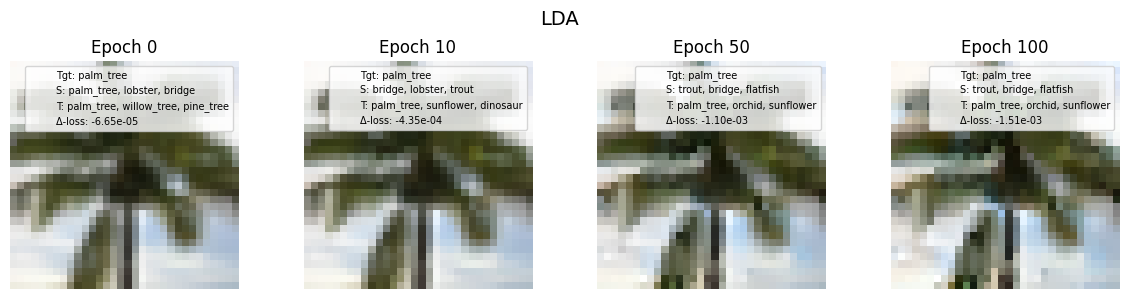

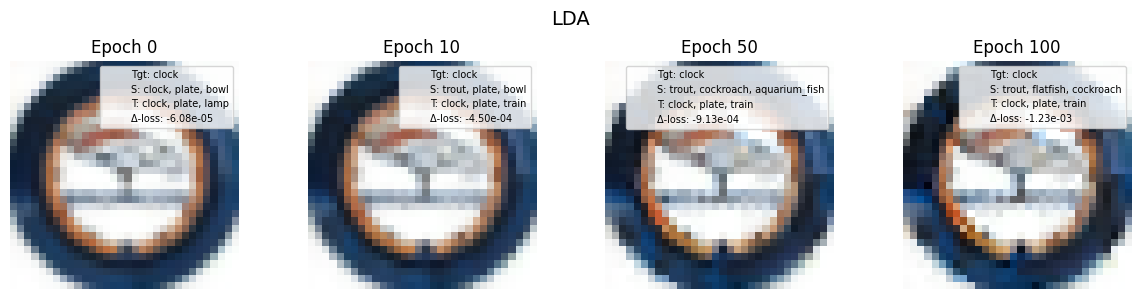

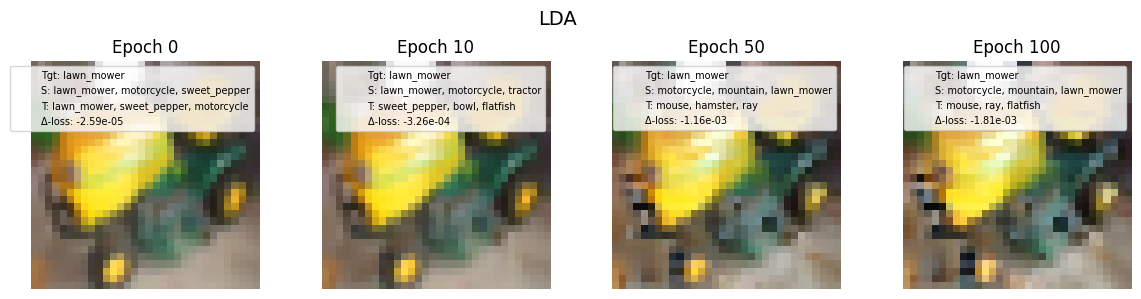

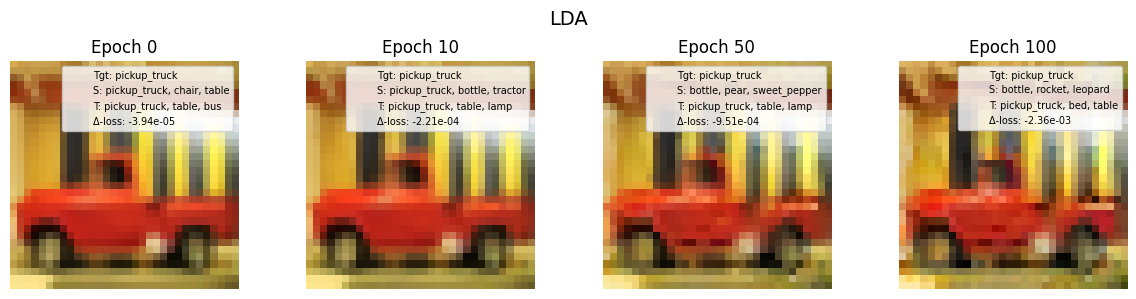

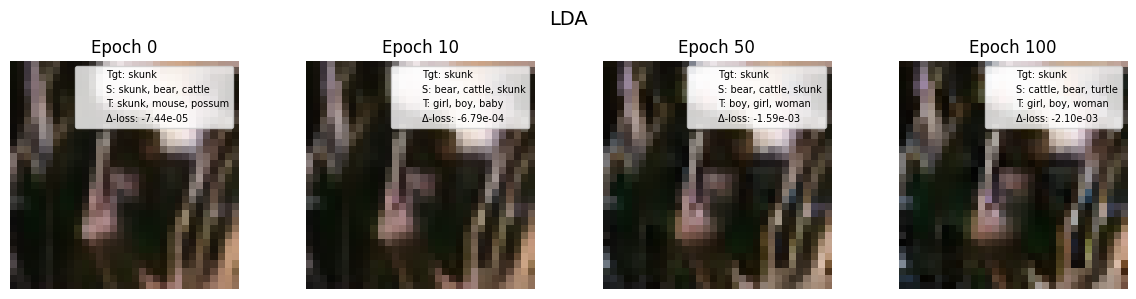

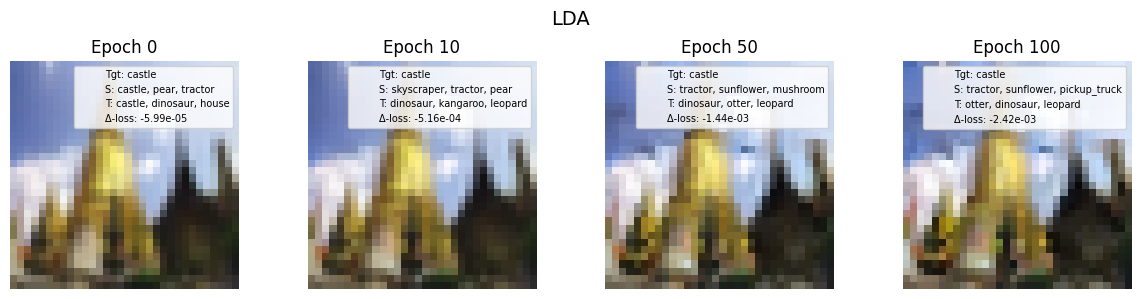

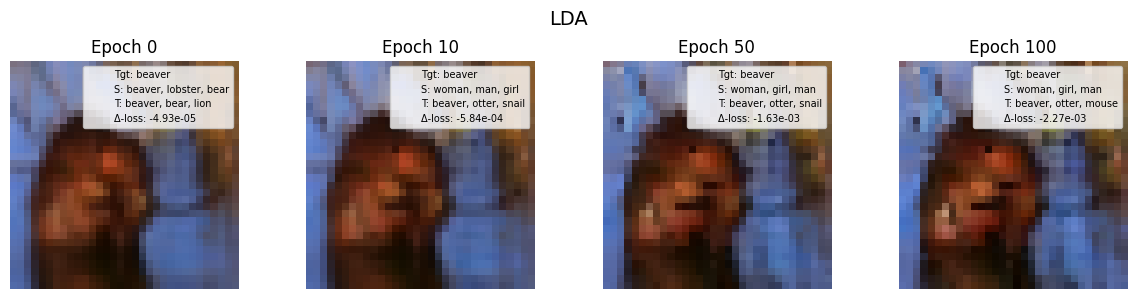

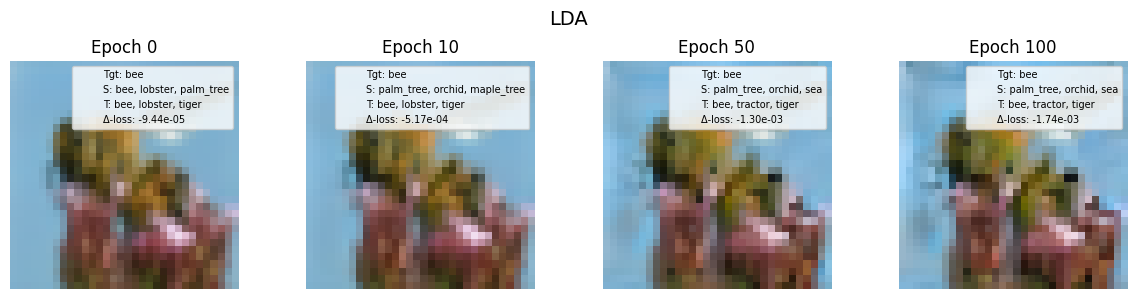

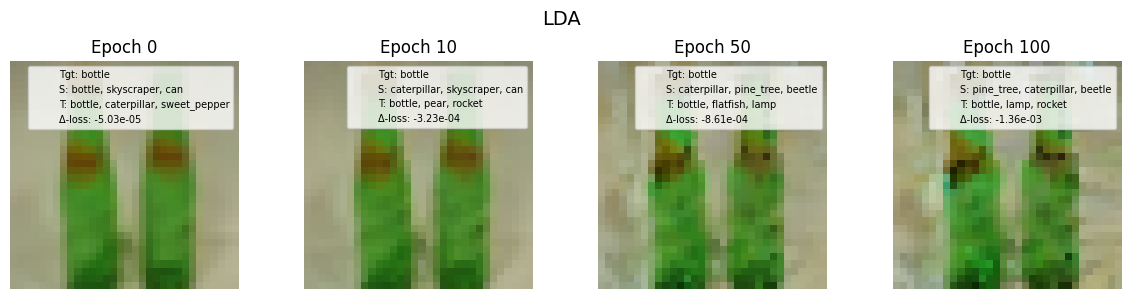

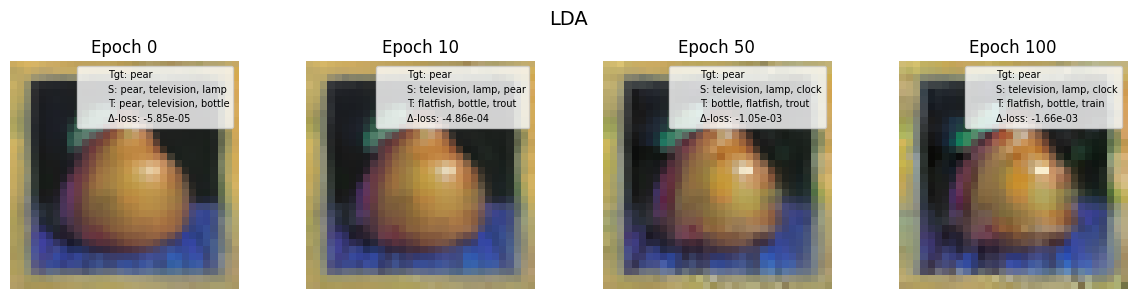

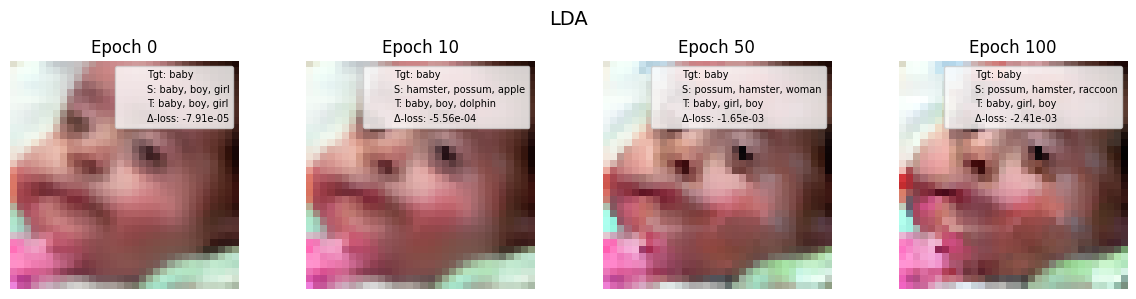

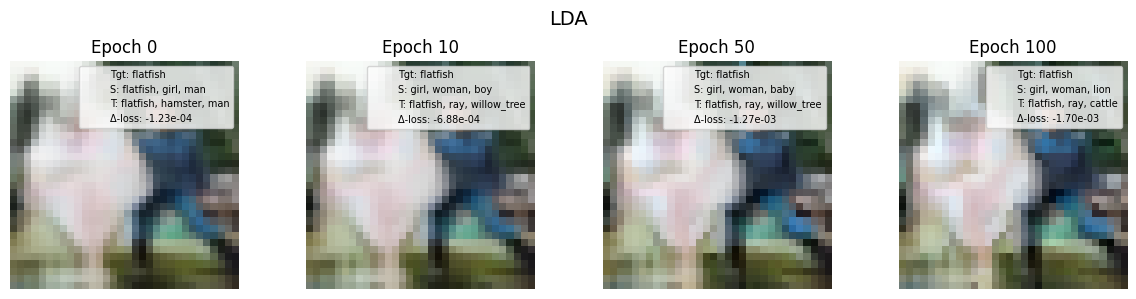

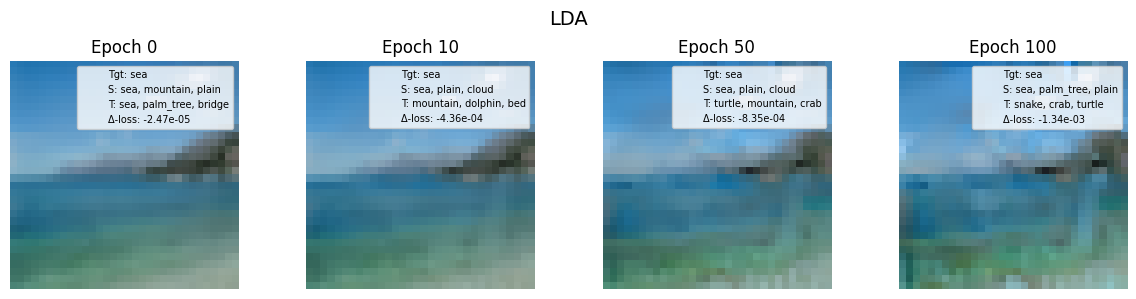

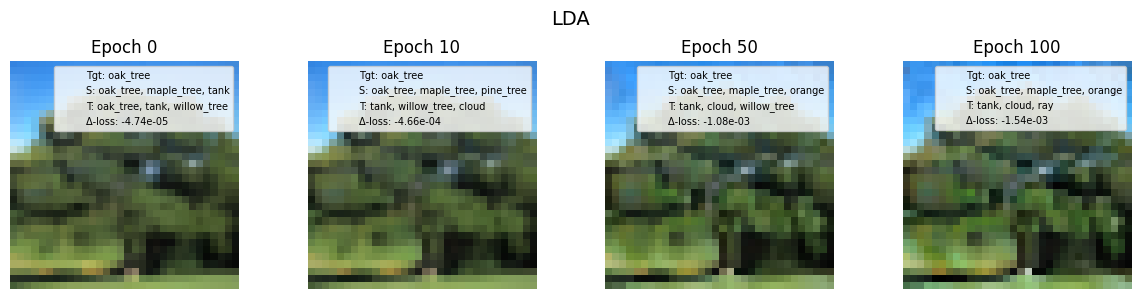

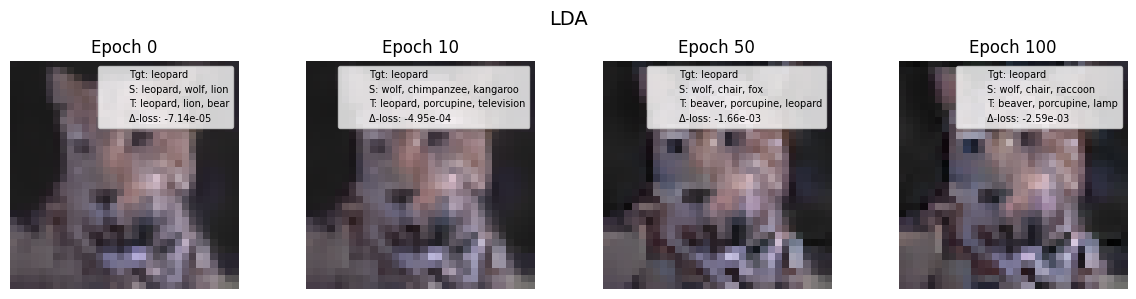

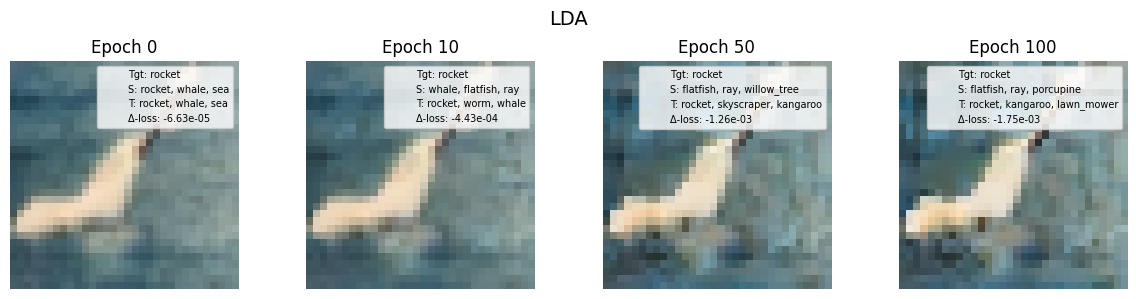

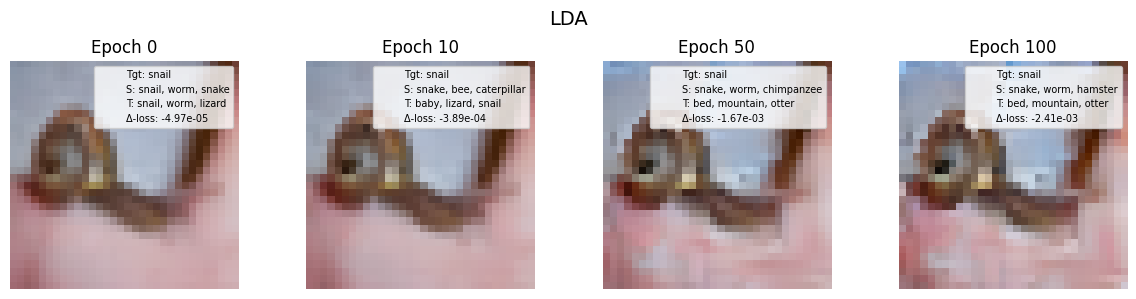

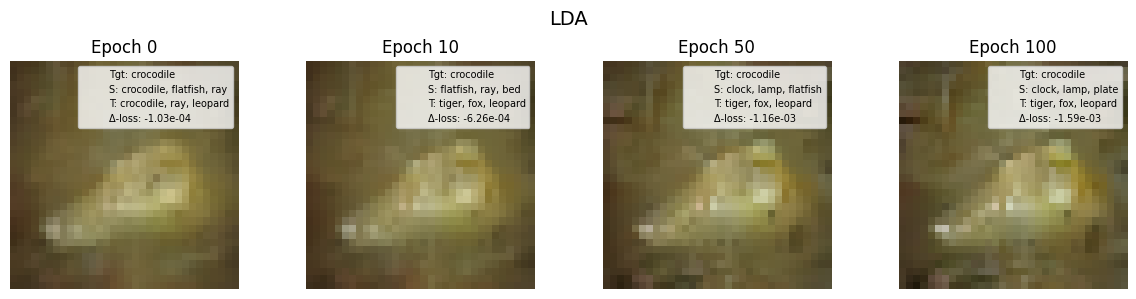

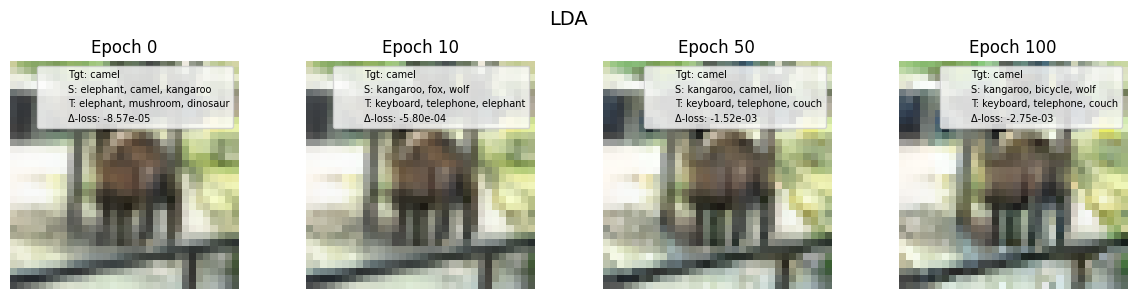

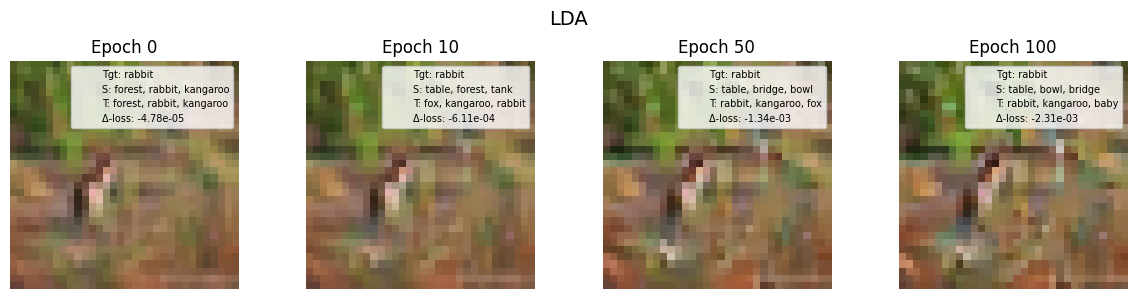

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from torchvision import datasets

# CIFAR-100 class index → label
id2label = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

def plot_row(images, titles, annotations, suptitle=None):
    """
    Plots a row of N images side-by-side, with titles[i] above each image
    and per-image legends from annotations[i]. Optionally adds a suptitle.
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
        if annotations[i]:
            ax.legend(handles=annotations[i], loc='upper right', fontsize=7)
    plt.tight_layout()
    return fig

# — USER CONFIGURABLE —
steps = [0, 10, 50, 100]
funcs = [("DA", DA), ("LDA", LDA)]
# — end config —

for before, target in val_loader:
    before = before.cuda()
    target = target.cpu()

    batch_size = before.shape[0]

    for name, func in funcs:
        # 1) generate images for this function
        images = [func(before, distiller.module, s) for s in steps]

        # 2) get logits
        student_logits = [distiller.module.student(x)[0].cpu() for x in images]
        teacher_logits = [distiller.module.teacher(x)[0].cpu() for x in images]

        # 3) compute disagreement losses
        loss_vals = []
        for s_log, t_log in zip(student_logits, teacher_logits):
            norm_s = F.normalize(s_log, p=1, dim=1)
            norm_t = F.normalize(t_log, p=1, dim=1)
            loss_vals.append(
                -1.0 * F.mse_loss(norm_s, norm_t, reduction='none').mean(dim=1)
            )

        # 4) denormalize & clamp
        images = [
            distiller.module.denormalize(x).clamp_(0, 1).cpu()
            for x in images
        ]

        # 5) per-sample plotting
        titles = [f"Epoch {s}" for s in steps]
        for i in range(batch_size):
            annots = []
            for j, (s_log, t_log) in enumerate(zip(student_logits, teacher_logits)):
                top_s = [id2label[c] for c in torch.topk(s_log[i], 3).indices.tolist()]
                top_t = [id2label[c] for c in torch.topk(t_log[i], 3).indices.tolist()]
                tgt = id2label[target[i].item()]
                loss_ij = loss_vals[j][i].item()
                annots.append([
                    Patch(color='none', label=f"Tgt: {tgt}"),
                    Patch(color='none', label=f"S: {', '.join(top_s)}"),
                    Patch(color='none', label=f"T: {', '.join(top_t)}"),
                    Patch(color='none', label=f"Δ-loss: {loss_ij:.2e}")
                ])

            # show DA or LDA plot for this sample
            fig = plot_row(
                [img[i] for img in images],
                titles,
                annots,
                suptitle=name  # "DA" or "LDA"
            )
            plt.show()

    break  # remove if you want more batches
